# NFL Project Notebook
## A blog-like summary of how I explored the play-by-play dataset of National Football League seasons from 2009 to 2017.
### I tried to highlight the key steps in my thought process throughout the notebook, while keeping it honest as in not listing insights until I've actually gained them by writing code and executing cells. This way I took a chronological approach in showing the steps of the project as opposed to only presenting the conclusions and results of my analysis and the application of my model while sharing the source code.
#### The dataset is from Max Horowitz (Kaggle user), https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016 (second csv file), nflscrapR generated NFL dataset with expected points and win probability.

### Setting up autoreload and imports

In [1]:
%load_ext autoreload
%autoreload 2

In [248]:
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
import numpy as np
import math
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, RandomTreesEmbedding
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz
from sklearn import metrics
import matplotlib.pyplot as plt
import datetime as dt
import calendar
import re
import requests
import bs4
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (20,10)
%matplotlib inline

### Useful (sometimes modified) functions from the fastai library
#### These all are very useful functions that make life much easier. The display_all_columns() function is one of those I modified, in this case to help me explore the features and their values in the dataset without displaying a large number of rows as the original display_all() function does.
##### All credit for the original functions goes to the authors of the fastai library (https://github.com/fastai).

In [3]:
# useful fastai functions

def add_datepart(df, fldname):
    fld = df[fldname]
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 
              'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
        df[targ_pre+'Elapsed'] = (fld - fld.min()).dt.days
    df.drop(fldname, axis=1, inplace=True)

def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c):
            df[n] = c.astype('category').cat.as_ordered()

def apply_cats(df, trn):
    for n,c in df.items():
        if trn[n].dtype.name == 'category':
            df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)

def display_all(df):
    with pd.option_context('display.max_rows', 10000):
        with pd.option_context('display.max_columns', 1000):
            display(df)
            
def display_all_columns(df):
    with pd.option_context('display.max_rows', 10):
        with pd.option_context('display.max_columns', 1000):
            display(df)

def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1
            
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):

    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

def print_score(m):
    res = [rmse(m.predict(X_train), y_train),
           rmse(m.predict(X_valid), y_valid),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    return res

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

### Looking at the features
#### Since I have a solid understanding of NFL rules (if I can say that at all with all the rule changes and vague definitions in the rulebook, e.g. the history of the 'catch' rule) and the flow of the game, I decided to take a look at all of the features of the dataset first, and see if I can define data types for hopefully most of them.
#### This will also help determine the whole purpose of the model building exercise, finding the dependent variable and making a decision on what kind of model I am going to use to predict the outcomes.
#### I specified the number of rows to be read in the read_csv function's 'nrows' parameter to be 5, and used the above mentioned display_all_columns() function to see all the columns of the DataFrame.

In [4]:
df_preview = pd.read_csv('NFL Play by Play 2009-2017 (v4).csv', nrows=5)
display_all_columns(df_preview)

Date      GameID  Drive  qtr  down   time  TimeUnder  TimeSecs  \
0  2009-09-10  2009091000      1    1   NaN  15:00         15      3600   
1  2009-09-10  2009091000      1    1   1.0  14:53         15      3593   
2  2009-09-10  2009091000      1    1   2.0  14:16         15      3556   
3  2009-09-10  2009091000      1    1   3.0  13:35         14      3515   
4  2009-09-10  2009091000      1    1   4.0  13:27         14      3507   

   PlayTimeDiff SideofField  yrdln  yrdline100  ydstogo  ydsnet  GoalToGo  \
0             0         TEN     30          30        0       0         0   
1             7         PIT     42          58       10       5         0   
2            37         PIT     47          53        5       2         0   
3            41         PIT     44          56        8       2         0   
4             8         PIT     44          56        8       2         0   

   FirstDown posteam DefensiveTeam  \
0        NaN     PIT           TEN   
1        0.0     PIT           TEN   
2        0.0     PIT           TEN   
3        0.0     PIT           TEN   
4        1.0     PIT           TEN   

                                                desc  PlayAttempted  \
0  R.Bironas kicks 67 yards from TEN 30 to PIT 3....              1   
1  (14:53) B.Roethlisberger pass short left to H....              1   
2  (14:16) W.Parker right end to PIT 44 for -3 ya...              1   
3  (13:35) (Shotgun) B.Roethlisberger pass incomp...              1   
4  (13:27) (Punt formation) D.Sepulveda punts 54 ...              1   

   Yards.Gained  sp  Touchdown  ExPointResult  TwoPointConv  DefTwoPoint  \
0            39   0          0            NaN           NaN          NaN   
1             5   0          0            NaN           NaN          NaN   
2            -3   0          0            NaN           NaN          NaN   
3             0   0          0            NaN           NaN          NaN   
4             0   0          0            NaN           NaN          NaN   

   Safety  Onsidekick PuntResult PlayType            Passer   Passer_ID  \
0       0           0        NaN  Kickoff               NaN        None   
1       0           0        NaN     Pass  B.Roethlisberger  00-0022924   
2       0           0        NaN      Run               NaN        None   
3       0           0        NaN     Pass  B.Roethlisberger  00-0022924   
4       0           0      Clean     Punt               NaN        None   

   PassAttempt      PassOutcome PassLength  AirYards  YardsAfterCatch  QBHit  \
0            0              NaN        NaN         0                0      0   
1            1         Complete      Short        -3                8      0   
2            0              NaN        NaN         0                0      0   
3            1  Incomplete Pass       Deep        34                0      0   
4            0              NaN        NaN         0                0      0   

  PassLocation  InterceptionThrown  Interceptor    Rusher   Rusher_ID  \
0          NaN                   0          NaN       NaN        None   
1         left                   0          NaN       NaN        None   
2          NaN                   0          NaN  W.Parker  00-0022250   
3        right                   0          NaN       NaN        None   
4          NaN                   0          NaN       NaN        None   

   RushAttempt RunLocation RunGap   Receiver Receiver_ID  Reception  \
0            0         NaN    NaN        NaN        None          0   
1            0         NaN    NaN     H.Ward  00-0017162          1   
2            1       right    end        NaN        None          0   
3            0         NaN    NaN  M.Wallace  00-0026901          0   
4            0         NaN    NaN        NaN        None          0   

   ReturnResult Returner  BlockingPlayer   Tackler1  Tackler2  \
0           NaN  S.Logan             NaN  M.Griffin       NaN   
1           NaN      NaN             NaN     C.Hope   

### Defining feature data types with the dtype parameter of pd.read_csv()
#### The dataset is provided in a csv format, and thankfully Pandas is great at handling it. Defining the types while reading in the data will make the time needed for processing shorter and will prove to be much more efficient than doing it with a separate function (e.g. astype()) for the columns in the dataframe later on. Float32 has been applied in many cases where we have numeric values, but some of them are missing so they couldn't be defined as integers and the difference between float and int didn't matter much (e.g. scores).

In [5]:
types = {'GameID':'int64',
        'Drive':'int8',
        'qtr':'int8',
        'down':'float32',
        'TimeUnder':'int8',
        'TimeSecs':'float32',
        'PlayTimeDiff':'float32',
        'yrdln':'float32',
        'yrdline100':'float32',
        'ydstogo':'int8',
        'ydsnet':'int8',
        'GoalToGo':'str',
        'FirstDown':'str',
        'PlayAttempted':'bool',
        'Yards.Gained':'float32',
        'sp':'bool',
        'Touchdown':'bool',
        'Safety':'bool',
        'Onsidekick':'bool',
        'PassAttempt':'bool',
        'AirYards':'int8',
        'YardsAfterCatch':'int8',
        'QBHit':'bool',
        'InterceptionThrown':'bool',
        'RushAttempt':'bool',
        'Reception':'bool',
        'FieldGoalDistance':'float32',
        'Fumble':'bool',
        'Sack':'bool',
        'Challenge.Replay':'bool',
        'Accepted.Penalty':'bool',
        'Penalty.Yards':'int8',
        'PosTeamScore':'float32',
        'DefTeamScore':'float32',
        'ScoreDiff':'float32',
        'AbsScoreDiff':'float32',
        'Timeout_Indicator':'bool',
        'posteam_timeouts_pre':'int8',
        'HomeTimeouts_Remaining_Pre':'int8',
        'AwayTimeouts_Remaining_Pre':'int8',
        'HomeTimeouts_Remaining_Post':'int8',
        'AwayTimeouts_Remaining_Post':'int8',
        'No_Score_Prob':'float32',
        'Opp_Field_Goal_Prob':'float32',
        'Opp_Safety_Prob':'float32',
        'Opp_Touchdown_Prob':'float32',
        'Field_Goal_Prob':'float32',
        'Safety_Prob':'float32',
        'Touchdown_Prob':'float32',
        'ExPoint_Prob':'float32',
        'TwoPoint_Prob':'float32',
        'ExpPts':'float32',
        'EPA':'float32',
        'airEPA':'float32',
        'yacEPA':'float32',
        'Home_WP_pre':'float32',
        'Away_WP_pre':'float32',
        'Home_WP_post':'float32',
        'Away_WP_post':'float32',
        'Win_Prob':'float32',
        'WPA':'float32',
        'airWPA':'float32',
        'yacWPA':'float32'}

### Reading the data from the csv file
#### Setting low_memory=False allows us to work with bigger datasets, while the parse_dates parameter converts any specified column's values into datetime type if they are in a recognisable date format, again saving us additional lines of code to achieve this just like dtype for the general data types.

In [6]:
df = pd.read_csv('NFL Play by Play 2009-2017 (v4).csv', dtype=types, low_memory=False, parse_dates=['Date'])

In [183]:
display_all_columns(df.head(70))

Date      GameID  Drive  qtr  down   time  TimeUnder  TimeSecs  \
0  2009-09-10  2009091000      1    1   NaN  15:00         15    3600.0   
1  2009-09-10  2009091000      1    1   1.0  14:53         15    3593.0   
2  2009-09-10  2009091000      1    1   2.0  14:16         15    3556.0   
3  2009-09-10  2009091000      1    1   3.0  13:35         14    3515.0   
4  2009-09-10  2009091000      1    1   4.0  13:27         14    3507.0   
..        ...         ...    ...  ...   ...    ...        ...       ...   
65 2009-09-10  2009091000     10    2   4.0  02:22          3    1942.0   
66 2009-09-10  2009091000     11    2   1.0  02:14          3    1934.0   
67 2009-09-10  2009091000     11    2   2.0  02:08          3    1928.0   
68 2009-09-10  2009091000     11    2   NaN  02:00          2    1920.0   
69 2009-09-10  2009091000     11    2   1.0  02:00          2    1920.0   

    PlayTimeDiff SideofField  yrdln  yrdline100  ydstogo  ydsnet GoalToGo  \
0            0.0         TEN   30.0        30.0        0       0        0   
1            7.0         PIT   42.0        58.0       10       5        0   
2           37.0         PIT   47.0        53.0        5       2        0   
3           41.0         PIT   44.0        56.0        8       2        0   
4            8.0         PIT   44.0        56.0        8       2        0   
..           ...         ...    ...         ...      ...     ...      ...   
65           6.0         PIT   13.0        13.0        6      60        0   
66           8.0         PIT   21.0        79.0       10       0        0   
67           6.0         PIT   21.0        79.0       10      12        0   
68           8.0         PIT   21.0        21.0        0      12        0   
69           0.0         PIT   33.0        67.0       10      16        0   

   FirstDown posteam DefensiveTeam  \
0        NaN     PIT           TEN   
1          0     PIT           TEN   
2          0     PIT           TEN   
3          0     PIT           TEN   
4          1     PIT           TEN   
..       ...     ...           ...   
65         1     TEN           PIT   
66         0     PIT           TEN   
67         1     PIT           TEN   
68       NaN     NaN           NaN   
69         0     PIT           TEN   

                                                 desc  PlayAttempted  \
0   R.Bironas kicks 67 yards from TEN 30 to PIT 3....           True   
1   (14:53) B.Roethlisberger pass short left to H....           True   
2   (14:16) W.Parker right end to PIT 44 for -3 ya...           True   
3   (13:35) (Shotgun) B.Roethlisberger pass incomp...           True   
4   (13:27) (Punt formation) D.Sepulveda punts 54 ...           True   
..                                                ...            ...   
65  (2:22) (Field Goal formation) R.Bironas 31 yar...           True   
66  (2:14) (Shotgun) B.Roethlisberger pass incompl...           True   
67  (2:08) (Shotgun) B.Roethlisberger pass short r...           True   
68                                 Two-Minute Warning           True   
69  (2:00) (Shotgun) B.Roethlisberger pass short r...           True   

    Yards.Gained     sp  Touchdown ExPointResult TwoPointConv DefTwoPoint  \
0           39.0  False      False           NaN          NaN         NaN   
1            5.0  False      False           NaN          NaN         NaN   
2           -3.0  False      False           NaN          NaN         NaN   
3            0.0  False      False           NaN          NaN         NaN   
4            0.0  False      False           NaN          NaN         NaN   
..           ...    ...        ...           ...          ...         ...   
65           0.0  False      False           NaN          NaN         NaN   
66           0.0  False      False           NaN          NaN         NaN   
67          12.0  False      False           NaN          NaN         NaN   
68           0.0  False      False           NaN          NaN         NaN   
69           4

### Data integrity - Modifications to clean the dataset
#### Updating the date for one game:<br>There is an error in the dataset where I needed to correct the date of a game, because it actually took place a day later than originally scheduled.
#### Changing the value for first downs:<br>In some cases first downs were not registered properly if a specific event followed the play, so I modified the affected rows.
#### I will go into detail about both later in the notebook (as I encountered them).

In [8]:
print(f"Buffalo Bills (home) - New York Jets (away) game date in 2014: {str(df.loc[(df['HomeTeam']=='BUF') & (df['AwayTeam']=='NYJ') & (df['Season']==2014), 'Date'].unique()[0])[:10]}")

Buffalo Bills (home) - New York Jets (away) game date in 2014: 2014-11-23


In [11]:
df.loc[(df['HomeTeam']=='BUF') & (df['AwayTeam']=='NYJ') & (df['Season']==2014), 'Date'] = pd.to_datetime('20141124', format='%Y%m%d')

In [12]:
df.loc[(df['ydstogo'] <= df['Yards.Gained']) & 
       ((df['PlayType'] == 'Pass') | (df['PlayType'] == 'Run')) &
        (df['sp'] == False) &
        (df['PenalizedTeam'] != df['posteam']) &
        (df['FirstDown'] == '0'), 'FirstDown'] = '1'

### Using describe() in our EDA
#### We need to apply the same display settings to describe() as it gives us a summary of useful statistics for columns with numeric values in the data frame. It helped me get a better grip at the values in e.g. the columns with scores and yards (PosTeamScore, ScoreDiff, ydstogo, Yards.Gained, etc.).

In [13]:
display_all_columns(df.describe())

GameID          Drive            qtr           down  \
count  4.076880e+05  407688.000000  407688.000000  346534.000000   
mean   2.013158e+09      12.316158       2.577412       2.002476   
std    2.572839e+06       7.149527       1.129750       1.006110   
min    2.009091e+09       1.000000       1.000000       1.000000   
25%    2.011101e+09       6.000000       2.000000       1.000000   
50%    2.013111e+09      12.000000       3.000000       2.000000   
75%    2.015121e+09      18.000000       4.000000       3.000000   
max    2.017123e+09      35.000000       5.000000       4.000000   

           TimeUnder       TimeSecs   PlayTimeDiff          yrdln  \
count  407688.000000  407464.000000  407244.000000  406848.000000   
mean        7.374200    1695.082764      20.576763      28.488327   
std         4.642388    1062.776855      17.971344      12.950655   
min         0.000000    -900.000000       0.000000       1.000000   
25%         3.000000     778.000000       5.000000      20.000000   
50%         7.000000    1800.000000      17.000000      30.000000   
75%        11.000000    2585.000000      37.000000      39.000000   
max        15.000000    3600.000000     943.000000      50.000000   

          yrdline100        ydstogo         ydsnet   Yards.Gained  \
count  406848.000000  407688.000000  407688.000000  407688.000000   
mean       48.657307       7.309403      25.945517       4.994221   
std        25.065981       4.869987      24.862079       9.092000   
min         1.000000       0.000000     -87.000000     -74.000000   
25%        30.000000       3.000000       5.000000       0.000000   
50%        49.000000       9.000000      19.000000       1.000000   
75%        70.000000      10.000000      43.000000       7.000000   
max        99.000000      50.000000      99.000000      99.000000   

            AirYards  YardsAfterCatch  FieldGoalDistance  Penalty.Yards  \
count  407688.000000    407688.000000        8948.000000  407688.000000   
mean        3.264006         1.252598          37.465134       0.613673   
std         7.511569         4.193132          10.282694       2.621540   
min       -70.000000       -81.000000          18.000000       0.000000   
25%         0.000000         0.000000          29.000000       0.000000   
50%         0.000000         0.000000          38.000000       0.000000   
75%         4.000000         0.000000          46.000000       0.000000   
max        84.000000        90.000000          71.000000      66.000000   

        PosTeamScore   DefTeamScore      ScoreDiff   AbsScoreDiff  \
count  380784.000000  380784.000000  382700.000000  380784.000000   
mean       10.201424      11.414484      -1.186590       7.783541   
std         9.430286       9.913246      10.741083       7.450680   
min         0.000000       0.000000     -59.000000       0.000000   
25%         2.000000       3.000000      -7.000000       3.000000   
50%         7.000000      10.000000       0.000000       7.000000   
75%        16.000000      17.000000       4.000000      11.000000   
max        61.000000      61.000000      59.000000      59.000000   

       posteam_timeouts_pre  HomeTimeouts_Remaining_Pre  \
count         407688.000000               407688.000000   
mean               2.521239                    2.540479   
std                0.778066                    0.760419   
min                0.000000                   -3.000000   
25%                2.000000                    2.000000   
50%                3.000000                    3.000000   
75%                3.000000                    3.000000   
max                3.000000                    3.000000   

       AwayTimeouts_Remaining_Pre  HomeTimeouts_Remaining_Post  \
count               407688.000000                407688.000000   
mean                     2.517222                     2.520118   
std                      0.778348                     0.780151   
min                     -1.000000                    -3.000000

### Selecting features
#### Since I intend to create a model for possible outcomes of plays (hence I'm using the play-by-play dataset), I'm only keeping columns that contain values known before a play is called by the team's coach. Anything that has information on what is going to happen with the play needs to go, as it might be something I would like to find out by myself (e.g. Yards.Gained or FirstDown).
### Finding the dependent variable
#### I'm planning to explore the 'FirstDown' column in more detail and than predict whether a play is going to result in a first down or not. A random forest classification model seems to be a good choice here.
### Handling missing values
#### Random forests (and tree based methods in general) are quite good with handling null values in data frames without modification, but there might be smarter ways to use them when it comes to prediction of the dependent variable based on the features of the dataframe. In this case for the 'FirstDown' column, it's reasonable to fill the missing values with 0s as these either weren't actual plays (e.g. timeout, end of quarter) or kickoffs to start a half, which even though by definition will give a first down to one of the teams are just the way the games start or continue after halftime. We could also just get rid of these rows, but I like to keep as much information as possible when first analysing a data set, and this will prove really important later when I make a note about issues with data integrity.

In [14]:
na_column_dict = {column:value for column,value in zip(df.columns,df.isnull().any())}
na_columns = [col for (col,value) in na_column_dict.items() if value==True]
na_columns

['down',
 'time',
 'TimeSecs',
 'PlayTimeDiff',
 'SideofField',
 'yrdln',
 'yrdline100',
 'GoalToGo',
 'FirstDown',
 'posteam',
 'DefensiveTeam',
 'desc',
 'ExPointResult',
 'TwoPointConv',
 'DefTwoPoint',
 'PuntResult',
 'Passer',
 'PassOutcome',
 'PassLength',
 'PassLocation',
 'Interceptor',
 'Rusher',
 'RunLocation',
 'RunGap',
 'Receiver',
 'ReturnResult',
 'Returner',
 'BlockingPlayer',
 'Tackler1',
 'Tackler2',
 'FieldGoalResult',
 'FieldGoalDistance',
 'RecFumbTeam',
 'RecFumbPlayer',
 'ChalReplayResult',
 'PenalizedTeam',
 'PenaltyType',
 'PenalizedPlayer',
 'PosTeamScore',
 'DefTeamScore',
 'ScoreDiff',
 'AbsScoreDiff',
 'No_Score_Prob',
 'Opp_Field_Goal_Prob',
 'Opp_Safety_Prob',
 'Opp_Touchdown_Prob',
 'Field_Goal_Prob',
 'Safety_Prob',
 'Touchdown_Prob',
 'ExpPts',
 'EPA',
 'airEPA',
 'yacEPA',
 'Home_WP_pre',
 'Away_WP_pre',
 'Home_WP_post',
 'Away_WP_post',
 'Win_Prob',
 'WPA',
 'airWPA',
 'yacWPA']

In [214]:
X = df[['Date','GameID','Drive','qtr','down','time','TimeUnder','TimeSecs','PlayTimeDiff','SideofField',
        'yrdln','yrdline100','ydstogo','GoalToGo','FirstDown','posteam','DefensiveTeam','PlayAttempted','PlayType',
        'Passer','Passer_ID','PassAttempt','PassLocation','Rusher','Rusher_ID','RushAttempt','RunLocation',
        'RunGap','PosTeamScore','DefTeamScore','ScoreDiff','AbsScoreDiff','HomeTeam','AwayTeam','Timeout_Indicator',
        'Timeout_Team','posteam_timeouts_pre','HomeTimeouts_Remaining_Pre','AwayTimeouts_Remaining_Pre',
        'HomeTimeouts_Remaining_Post','AwayTimeouts_Remaining_Post','Season']].copy()
X['FirstDown'].fillna(0,inplace=True)
X['FirstDown'] = X['FirstDown'].astype(int)

### A little bit of football and why we should be looking at first downs while thinking about winning
#### I always like to think about side projects as if they had real world applications. When it comes to football games, it's rather obvious that both teams want to win and to do so they need to score more points than their opponent. Breaking this down a bit more, the most points that can be scored at once is 6. This can happen with either an offensive or defensive touchdown and it also gives the opportunity to the scoring team to add another 1 or 2 points by kicking an extra point or converting on a 2-point conversion attempt respectively. To get closer to the end zone and give themselves more opportunities to score, teams need to advance by moving forward for at least 10 yards in a maximum of 4 tries each time. Achieving this is called a first down as the number of tries resets (and goes up to fourth again if the team cannot advance for at least 10 yards in the next 3 tries). As it is easier to score if the team is closer to the opponent's end zone and each first down rewards the offensive team with a fresh set of downs, we can say that - to some extent - first downs are essential to win NFL games with offensive football (which has been dominant in recent years).
### The relationship between first downs achieved and the outcome of games - Webscraping
#### Web scraping  profootballreference.com with BeautifulSoup to gather data about NFL game outcomes between 2009 and 2017 and visualising it with Matplotlib.
##### All credits for the useful functions belong to Ben Kite who created these specifically for profootballreference.com and therefore saved time for me with it (https://github.com/BenKite/football_data/blob/master/profootballReferenceScrape.py)

In [16]:
def findTables(url):
    res = requests.get(url)
    comm = re.compile("<!--|-->")
    soup = bs4.BeautifulSoup(comm.sub("", res.text), 'lxml')
    divs = soup.findAll('div', id = "content")
    divs = divs[0].findAll("div", id=re.compile("^all"))
    ids = []
    for div in divs:
        searchme = str(div.findAll("table"))
        x = searchme[searchme.find("id=") + 3: searchme.find(">")]
        x = x.replace("\"", "")
        if len(x) > 0:
            ids.append(x)
    return(ids)

def pullTable(url, tableID, header = True):
    res = requests.get(url)
    ## Work around comments
    comm = re.compile("<!--|-->")
    soup = bs4.BeautifulSoup(comm.sub("", res.text), 'lxml')
    tables = soup.findAll('table', id = tableID)
    data_rows = tables[0].findAll('tr')
    game_data = [[td.getText() for td in data_rows[i].findAll(['th','td'])]
        for i in range(len(data_rows))
        ]
    data = pd.DataFrame(game_data)
    if header == True:
        data_header = tables[0].findAll('thead')
        data_header = data_header[0].findAll("tr")
        data_header = data_header[0].findAll("th")
        header = []
        for i in range(len(data.columns)):
            header.append(data_header[i].getText())
        data.columns = header
        data = data.loc[data[header[0]] != header[0]]
    data = data.reset_index(drop = True)
    return(data)

#### Gathering information from all relevant seasons. Since these are stored on separate pages of the website, I iterated through all of them and created one dataframe from the data.

In [17]:
for i in range(2009,2018):
    url = f'https://www.pro-football-reference.com/years/{i}/games.htm'
    table_ids = findTables(url)
    new_season = pullTable(url, table_ids[0], header = True)
    new_season.loc[:,'Season'] = i   
    if 'games_df_all' in locals():
        games_df_all = pd.concat([games_df_all,new_season], ignore_index=True)
    else:
        games_df_all = new_season

#### Filtering out post-seasons and post-season headers as these aren't present in the Kaggle dataset

In [18]:
games_df = games_df_all.loc[(games_df_all['Week'] != 'WildCard') & (games_df_all['Week'] != 'Division')
                            & (games_df_all['Week'] != 'ConfChamp') & (games_df_all['Week'] != 'SuperBowl')
                            & (games_df_all['Week'] != '')]

#### Adding a 'Full date' column to help match the games in the 2 dataframes.

In [19]:
date_list = [str(season)+' '+date if date[:7] != 'January' else str(season + 1)+' '+date for season, date in zip(games_df.loc[:,'Season'],games_df.loc[:,'Date'])]
games_df.loc[:,'Full date'] = date_list
games_df.loc[:,'Full date'] = pd.to_datetime(games_df.loc[:,'Full date'].copy(), format='%Y %B %d').dt.strftime('%Y-%m-%d')
display_all(games_df)

C:\Users\balaz\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\balaz\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Week  Day          Date     Time            Winner/tie     \
0       1  Thu  September 10   8:41PM   Pittsburgh Steelers      
1       1  Sun  September 13   1:02PM    Indianapolis Colts      
2       1  Sun  September 13   1:02PM      Baltimore Ravens      
3       1  Sun  September 13   1:02PM        Denver Broncos  @   
4       1  Sun  September 13   1:03PM         New York Jets  @   
5       1  Sun  September 13   1:03PM     Minnesota Vikings  @   
6       1  Sun  September 13   1:03PM    New Orleans Saints      
7       1  Sun  September 13   1:03PM        Dallas Cowboys  @   
8       1  Sun  September 13   1:04PM   Philadelphia Eagles  @   
9       1  Sun  September 13   1:05PM       Atlanta Falcons      
10      1  Sun  September 13   1:15PM   San Francisco 49ers  @   
11      1  Sun  September 13   4:15PM       New York Giants      
12      1  Sun  September 13   4:16PM      Seattle Seahawks      
13      1  Sun  September 13   8:30PM     Green Bay Packers      
14      1  Mon  September 14   7:10PM  New England Patriots      
15      1  Mon  September 14  10:16PM    San Diego Chargers  @   
16      2  Sun  September 20   1:00PM       Oakland Raiders  @   
17      2  Sun  September 20   1:02PM    Cincinnati Bengals  @   
18      2  Sun  September 20   1:02PM         New York Jets      
19      2  Sun  September 20   1:02PM       Atlanta Falcons      
20      2  Sun  September 20   1:02PM   Washington Redskins      
21      2  Sun  September 20   1:03PM     Minnesota Vikings  @   
22      2  Sun  September 20   1:03PM        Houston Texans  @   
23      2  Sun  September 20   1:03PM     Arizona Cardinals  @   
24      2  Sun  September 20   1:04PM    New Orleans Saints  @   
25      2  Sun  September 20   4:05PM   San Francisco 49ers      
26      2  Sun  September 20   4:05PM         Buffalo Bills      
27      2  Sun  September 20   4:15PM        Denver Broncos      
28      2  Sun  September 20   4:15PM      Baltimore Ravens  @   
29      2  Sun  September 20   4:15PM         Chicago Bears      
30      2  Sun  September 20   8:20PM       New York Giants  @   
31      2  Mon  September 21   8:42PM    Indianapolis Colts  @   
32      3  Sun  September 27   1:00PM     Green Bay Packers  @   
33      3  Sun  September 27   1:00PM       New York Giants  @   
34      3  Sun  September 27   1:02PM   Philadelphia Eagles      
35      3  Sun  September 27   1:02PM         Detroit Lions      
36      3  Sun  September 27   1:02PM  New England Patriots      
37      3  Sun  September 27   1:02PM      Baltimore Ravens      
38      3  Sun  September 27   1:03PM  Jacksonville Jaguars  @   
39      3  Sun  September 27   1:03PM         New York Jets      
40      3  Sun  September 27   1:03PM     Minnesota Vikings      
41      3  Sun  September 27   4:05PM    New Orleans Saints  @   
42      3  Sun  September 27   4:06PM         Chicago Bears  @   
43      3  Sun  September 27   4:15PM    San Diego Chargers      
44      3  Sun  September 27   4:15PM    Cincinnati Bengals      
45      3  Sun  September 27   4:15PM        Denver Broncos  @   
46      3  Sun  September 27   8:31PM    Indianapolis Colts  @   
47      3  Mon  September 28   8:40PM        Dallas Cowboys      
48      4  Sun     October 4   1:00PM       New York Giants  @   
49      4  Sun     October 4   1:00PM   Washington Redskins      
50      4  Sun     October 4   1:02PM  New England Patriots      
51      4  Sun     October 4   1:02PM         Chicago Bears      
52      4  Sun     October 4   1:02PM        Houston Texans      
53      4  Sun     October 4   1:03PM    Indianapolis Colts      
54      4  Sun     October 4   1:03PM    Cincinnati Bengals  @   
55      4  Sun     October 4   1:05PM  Jacksonville Jaguars      
56      4  Sun     October 4   4:05PM    New Orleans Saints      
57      4  Sun     October 4   4:05PM        Miami Dolphins      
58      4  Sun     October 4   4:15PM        Denver Broncos      
59      4  Sun     October 4   4:15PM   San F

#### Checking for ties. There have only been 5 times when teams didn't manage to decide a regular season game in overtime in the 9 seasons observed.

In [20]:
display_all(games_df.loc[games_df['PtsW']==games_df['PtsL']])

Week  Day         Date    Time           Winner/tie     \
947    10  Sun  November 11  4:25PM  San Francisco 49ers      
1237   12  Sun  November 24  1:02PM    Minnesota Vikings  @   
1424    6  Sun   October 12  1:03PM   Cincinnati Bengals      
1981    7  Sun   October 23  8:30PM     Seattle Seahawks  @   
1984    8  Sun   October 30  8:36AM  Washington Redskins  @   

               Loser/tie           PtsW PtsL YdsW TOW YdsL TOL  Season  \
947       St. Louis Rams  boxscore   24   24  341   0  458   1    2012   
1237   Green Bay Packers  boxscore   26   26  447   1  494   0    2013   
1424   Carolina Panthers  boxscore   37   37  513   2  431   1    2014   
1981   Arizona Cardinals  boxscore    6    6  257   0  443   0    2016   
1984  Cincinnati Bengals  boxscore   27   27  546   1  415   2    2016   

       Full date  
947   2012-11-11  
1237  2013-11-24  
1424  2014-10-12  
1981  2016-10-23  
1984  2016-10-30

#### Creating a dictionary for team names and abbreviations as the teams are noted differently in the 2 dataframes. I could copy these from https://www.predictem.com/nfl/nfl-football-acronyms-abbreviations/, but had to update them to include relocated teams' new names and different abbreviations e.g. 'SD': 'San Diego Chargers' and 'LAC': 'Los Angeles Chargers'.

In [21]:
team_names_dict = {
'ARI': 'Arizona Cardinals',
'ATL': 'Atlanta Falcons',
'BAL': 'Baltimore Ravens',
'BUF': 'Buffalo Bills',
'CAR': 'Carolina Panthers',
'CHI': 'Chicago Bears',
'CIN': 'Cincinnati Bengals',
'CLE': 'Cleveland Browns',
'DAL': 'Dallas Cowboys',
'DEN': 'Denver Broncos',
'DET': 'Detroit Lions',
'GB': 'Green Bay Packers',
'HOU': 'Houston Texans',
'IND': 'Indianapolis Colts',
'JAX': 'Jacksonville Jaguars',
'JAC': 'Jacksonville Jaguars',
'KC': 'Kansas City Chiefs',
'MIA': 'Miami Dolphins',
'MIN': 'Minnesota Vikings',
'NE': 'New England Patriots',
'NO': 'New Orleans Saints',
'NYG': 'New York Giants',
'NYJ': 'New York Jets',
'OAK': 'Oakland Raiders',
'PHI': 'Philadelphia Eagles',
'PIT': 'Pittsburgh Steelers',
'SD': 'San Diego Chargers',
'LAC': 'Los Angeles Chargers',
'SEA': 'Seattle Seahawks',
'SF': 'San Francisco 49ers',
'STL': 'St. Louis Rams',
'LA': 'Los Angeles Rams',
'TB': 'Tampa Bay Buccaneers',
'TEN': 'Tennessee Titans',
'WAS': 'Washington Redskins'}

#### Copying the dataframe with the selected features (X) to apply the modifications needed and create the pivot table from it where we have the first downs summed per game per team. The additional columns will be filled in with the pro-football-reference data.

In [22]:
X_copy = X.copy()
X_copy.loc[:,'Date'] = X_copy.loc[:,'Date'].dt.strftime('%Y-%m-%d')
X_copy.loc[:,'posteam'] = [team_names_dict[x] if str(x) != 'nan' else None for x in X_copy.loc[:,'posteam']]
first_down_df = pd.pivot_table(X_copy, index=['Date','posteam'], values=['FirstDown'], aggfunc={'FirstDown':np.sum})
first_down_df.loc[:,'PointsScored'] = '-'
first_down_df.loc[:,'GameResult'] = '-'
first_down_df.loc[:,'FDs_Compared_to_opponent'] = '-'
display_all(first_down_df)

FirstDown PointsScored GameResult  \
Date       posteam                                                   
2009-09-10 Pittsburgh Steelers          28            -          -   
           Tennessee Titans             25            -          -   
2009-09-13 Arizona Cardinals            28            -          -   
           Atlanta Falcons              24            -          -   
           Baltimore Ravens             33            -          -   
           Carolina Panthers            25            -          -   
           Chicago Bears                26            -          -   
           Cincinnati Bengals           26            -          -   
           Cleveland Browns             26            -          -   
           Dallas Cowboys               18            -          -   
           Denver Broncos               18            -          -   
           Detroit Lions                22            -          -   
           Green Bay Packers            19            -          -   
           Houston Texans               21            -          -   
           Indianapolis Colts           26            -          -   
           Jacksonville Jaguars         20            -          -   
           Kansas City Chiefs           16            -          -   
           Miami Dolphins               25            -          -   
           Minnesota Vikings            21            -          -   
           New Orleans Saints           28            -          -   
           New York Giants              23            -          -   
           New York Jets                26            -          -   
           Philadelphia Eagles          23            -          -   
           San Francisco 49ers          21            -          -   
           Seattle Seahawks             28            -          -   
           St. Louis Rams               25            -          -   
           Tampa Bay Buccaneers         31            -          -   
           Washington Redskins          19            -          -   
2009-09-14 Buffalo Bills                21            -          -   
           New England Patriots         32            -          -   
           Oakland Raiders              26            -          -   
           San Diego Chargers           26            -          -   
2009-09-20 Arizona Cardinals            26            -          -   
           Atlanta Falcons              27            -          -   
           Baltimore Ravens             24            -          -   
           Buffalo Bills                26            -          -   
           Carolina Panthers            31            -          -   
           Chicago Bears                22            -          -   
           Cincinnati Bengals           27            -          -   
           Cleveland Browns             20            -          -   
           Dallas Cowboys               25            -          -   
           Denver Broncos               29            -          -   
           Detroit Lions                25            -          -   
           Green Bay Packers            26            -          -   
           Houston Texans               23            -          -   
           Jacksonville Jaguars         26            -          -   
           Kansas City Chiefs           37            -          -   
           Minnesota Vikings            20            -          -   
           New England Patriots         28            -          -   
           New Orleans Saints           24            -          -   
           New York Giants              24            -          -   
           New York Jets                22            -          -   
           Oakland Raiders              18            -          -   
           Philadelphia Eagles          29            -          -   
           Pittsburgh Steelers          25            -          -   
           San Diego Chargers           27 

### Catching an error in the dataset - explanation for the date update for a game from the beginning
#### As I was matching the two dataframes by the dates and teams, I found a mistake in the original play-by-play dataset. A quick google search confirmed that the Buffalo Bills - New York Jets game was moved from Sunday to Monday (the location changed from Buffalo to Detroit as well), because of adverse weather conditions in November, 2014. This was tracked accordingly in the second dataframe from pro-football-reference, but the dataset from Kaggle still showed Sunday to be the date for the game.<br>(https://www.nytimes.com/2014/11/21/sports/football/bills-home-game-against-jets-will-be-relocated.html)

#### I updated this single exception above.

In [23]:
for date in first_down_df.index.levels[0]:
    for winner,loser in zip(games_df[games_df['Full date']==date]['Winner/tie'],games_df[games_df['Full date']==date]['Loser/tie']):
        try:
            first_down_df.loc[(date,winner),'PointsScored'] = int(games_df.loc[(games_df['Full date']==date) & (games_df['Winner/tie']==winner),'PtsW'])
            first_down_df.loc[(date,loser),'PointsScored'] = int(games_df.loc[(games_df['Full date']==date) & (games_df['Loser/tie']==loser),'PtsL'])
            if int(games_df.loc[(games_df['Full date']==date) & (games_df['Winner/tie']==winner),'PtsW']) == int(games_df.loc[(games_df['Full date']==date) & (games_df['Loser/tie']==loser),'PtsL']):
                first_down_df.loc[(date,winner),'GameResult'] = 'Tie'
                first_down_df.loc[(date,loser),'GameResult'] = 'Tie'
            else:
                first_down_df.loc[(date,winner),'GameResult'] = 'Won'
                first_down_df.loc[(date,loser),'GameResult'] = 'Lost'
            if first_down_df.loc[(date,winner),'FirstDown'] > first_down_df.loc[(date,loser),'FirstDown']:
                    first_down_df.loc[(date,winner),'FDs_Compared_to_opponent'] = 'More'
                    first_down_df.loc[(date,loser),'FDs_Compared_to_opponent'] = 'Less'
            elif first_down_df.loc[(date,winner),'FirstDown'] < first_down_df.loc[(date,loser),'FirstDown']:
                    first_down_df.loc[(date,winner),'FDs_Compared_to_opponent'] = 'Less'
                    first_down_df.loc[(date,loser),'FDs_Compared_to_opponent'] = 'More'
            else:
                    first_down_df.loc[(date,winner),'FDs_Compared_to_opponent'] = 'Equal'
                    first_down_df.loc[(date,loser),'FDs_Compared_to_opponent'] = 'Equal'                
        except KeyError:
            print(date, winner, loser)

In [24]:
display_all(first_down_df)

FirstDown  PointsScored GameResult  \
Date       posteam                                                    
2009-09-10 Pittsburgh Steelers          28            13        Won   
           Tennessee Titans             25            10       Lost   
2009-09-13 Arizona Cardinals            28            16       Lost   
           Atlanta Falcons              24            19        Won   
           Baltimore Ravens             33            38        Won   
           Carolina Panthers            25            10       Lost   
           Chicago Bears                26            15       Lost   
           Cincinnati Bengals           26             7       Lost   
           Cleveland Browns             26            20       Lost   
           Dallas Cowboys               18            34        Won   
           Denver Broncos               18            12        Won   
           Detroit Lions                22            27       Lost   
           Green Bay Packers            19            21        Won   
           Houston Texans               21             7       Lost   
           Indianapolis Colts           26            14        Won   
           Jacksonville Jaguars         20            12       Lost   
           Kansas City Chiefs           16            24       Lost   
           Miami Dolphins               25             7       Lost   
           Minnesota Vikings            21            34        Won   
           New Orleans Saints           28            45        Won   
           New York Giants              23            23        Won   
           New York Jets                26            24        Won   
           Philadelphia Eagles          23            38        Won   
           San Francisco 49ers          21            20        Won   
           Seattle Seahawks             28            28        Won   
           St. Louis Rams               25             0       Lost   
           Tampa Bay Buccaneers         31            21       Lost   
           Washington Redskins          19            17       Lost   
2009-09-14 Buffalo Bills                21            24       Lost   
           New England Patriots         32            25        Won   
           Oakland Raiders              26            20       Lost   
           San Diego Chargers           26            24        Won   
2009-09-20 Arizona Cardinals            26            31        Won   
           Atlanta Falcons              27            28        Won   
           Baltimore Ravens             24            31        Won   
           Buffalo Bills                26            33        Won   
           Carolina Panthers            31            20       Lost   
           Chicago Bears                22            17        Won   
           Cincinnati Bengals           27            31        Won   
           Cleveland Browns             20             6       Lost   
           Dallas Cowboys               25            31       Lost   
           Denver Broncos               29            27        Won   
           Detroit Lions                25            13       Lost   
           Green Bay Packers            26            24       Lost   
           Houston Texans               23            34        Won   
           Jacksonville Jaguars         26            17       Lost   
           Kansas City Chiefs           37            10       Lost   
           Minnesota Vikings            20            27        Won   
           New England Patriots         28             9       Lost   
           New Orleans Saints           24            48        Won   
           New York Giants              24            33        Won   
           New York Jets                22            16        Won   
           Oakland Raiders              18            13        Won   
           Philadelphia Eagles          29            22       Lost   
           Pittsburgh Steelers          25            14 

#### Let's visualise the data and see if their is a connection between the total number of first downs achieved and the points scored.

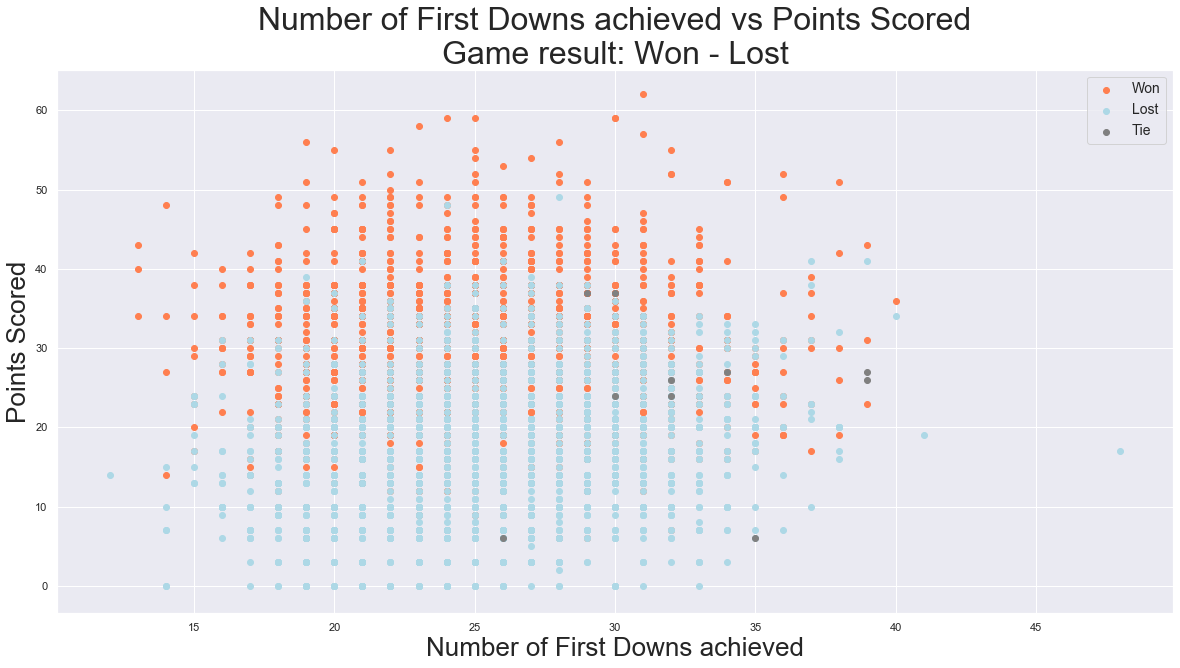

In [337]:
plt.scatter(first_down_df.loc[first_down_df['GameResult']=='Won','FirstDown'], first_down_df.loc[first_down_df['GameResult']=='Won','PointsScored'], c='coral')
plt.scatter(first_down_df.loc[first_down_df['GameResult']=='Lost','FirstDown'], first_down_df.loc[first_down_df['GameResult']=='Lost','PointsScored'], c='lightblue')
plt.scatter(first_down_df.loc[first_down_df['GameResult']=='Tie','FirstDown'], first_down_df.loc[first_down_df['GameResult']=='Tie','PointsScored'], c='grey')
plt.title('Number of First Downs achieved vs Points Scored\nGame result: Won - Lost',fontsize=32)
plt.xlabel('Number of First Downs achieved',fontsize=26)
plt.ylabel('Points Scored',fontsize=26)
plt.legend(['Won', 'Lost', 'Tie'], fontsize=14)
plt.rcParams["figure.figsize"] = (20,10)

#### And the colours for the "first down battle".

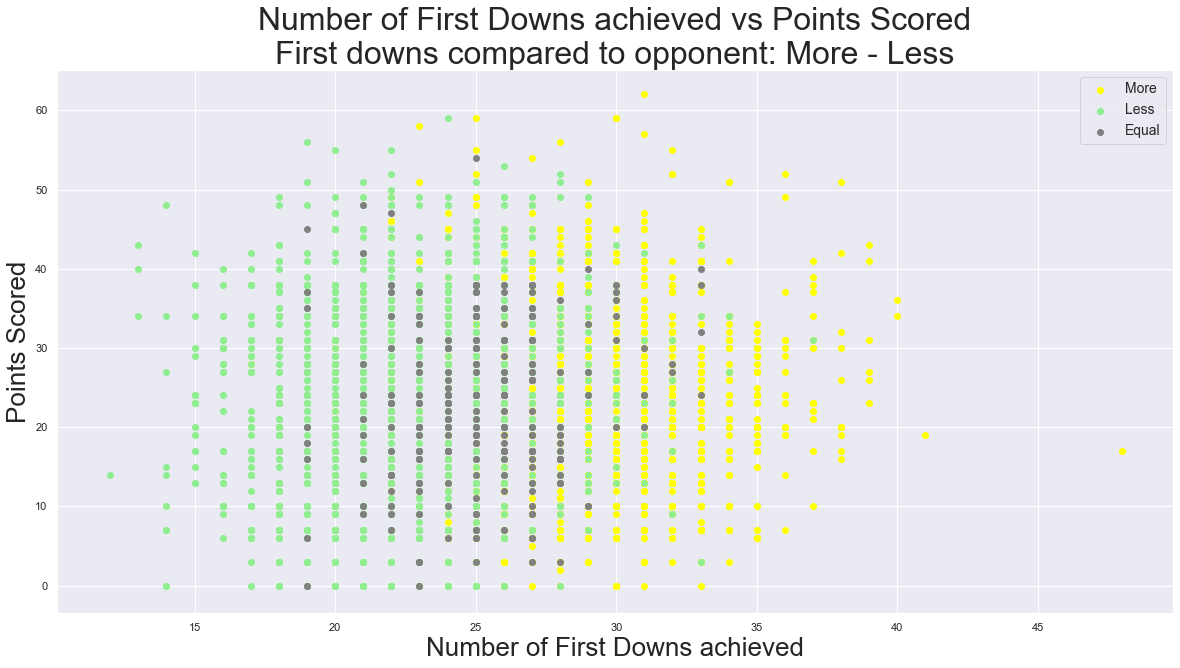

In [273]:
plt.scatter(first_down_df.loc[first_down_df['FDs_Compared_to_opponent']=='More','FirstDown'], first_down_df.loc[first_down_df['FDs_Compared_to_opponent']=='More','PointsScored'], c='yellow')
plt.scatter(first_down_df.loc[first_down_df['FDs_Compared_to_opponent']=='Less','FirstDown'], first_down_df.loc[first_down_df['FDs_Compared_to_opponent']=='Less','PointsScored'], c='lightgreen')
plt.scatter(first_down_df.loc[first_down_df['FDs_Compared_to_opponent']=='Equal','FirstDown'], first_down_df.loc[first_down_df['FDs_Compared_to_opponent']=='Equal','PointsScored'], c='grey')
plt.title('Number of First Downs achieved vs Points Scored\nFirst downs compared to opponent: More - Less',fontsize=32)
plt.xlabel('Number of First Downs achieved',fontsize=26)
plt.ylabel('Points Scored',fontsize=26)
plt.legend(['More', 'Less', 'Equal'], fontsize=14)

#### Now let me exclude ties and games where teams achieved the same number of first downs to see if there is any obvious correlation between winning the 'first down battle' and the game itself.

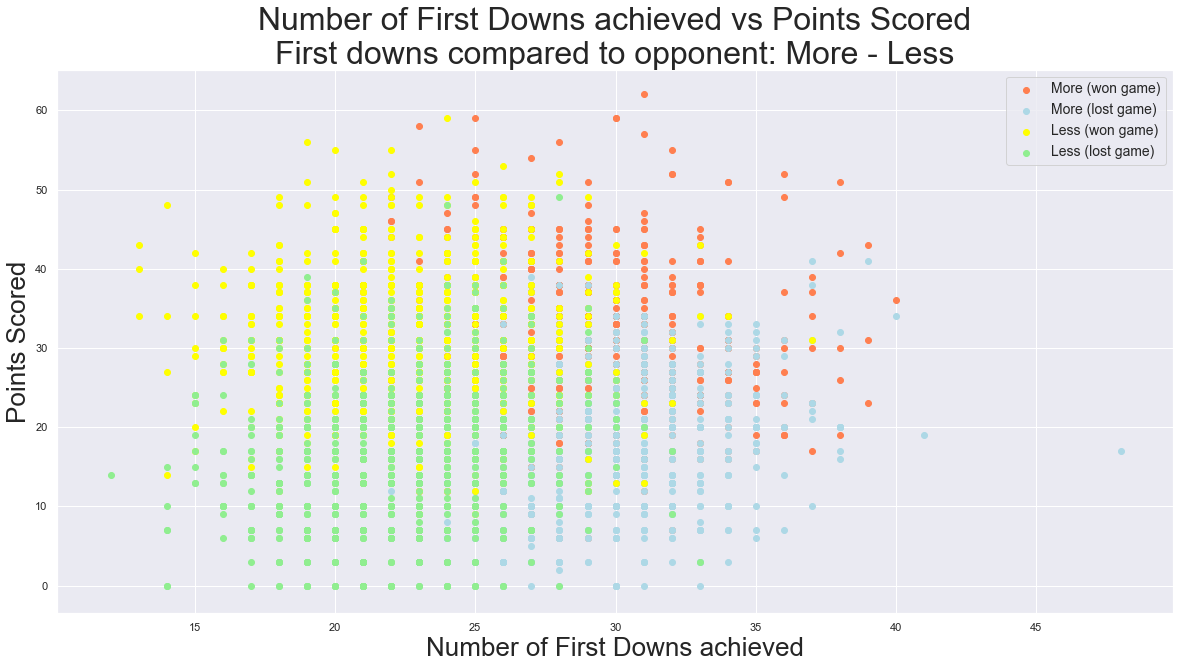

In [274]:
plt.scatter(first_down_df.loc[(first_down_df['GameResult']=='Won') & (first_down_df['FDs_Compared_to_opponent']=='More'),'FirstDown'], first_down_df.loc[(first_down_df['GameResult']=='Won') & (first_down_df['FDs_Compared_to_opponent']=='More'),'PointsScored'], c='coral')
plt.scatter(first_down_df.loc[(first_down_df['GameResult']=='Lost') & (first_down_df['FDs_Compared_to_opponent']=='More'),'FirstDown'], first_down_df.loc[(first_down_df['GameResult']=='Lost') & (first_down_df['FDs_Compared_to_opponent']=='More'),'PointsScored'], c='lightblue')
plt.scatter(first_down_df.loc[(first_down_df['GameResult']=='Won') & (first_down_df['FDs_Compared_to_opponent']=='Less'),'FirstDown'], first_down_df.loc[(first_down_df['GameResult']=='Won') & (first_down_df['FDs_Compared_to_opponent']=='Less'),'PointsScored'], c='yellow')
plt.scatter(first_down_df.loc[(first_down_df['GameResult']=='Lost') & (first_down_df['FDs_Compared_to_opponent']=='Less'),'FirstDown'], first_down_df.loc[(first_down_df['GameResult']=='Lost') & (first_down_df['FDs_Compared_to_opponent']=='Less'),'PointsScored'], c='lightgreen')
plt.title('Number of First Downs achieved vs Points Scored\nFirst downs compared to opponent: More - Less',fontsize=32)
plt.xlabel('Number of First Downs achieved',fontsize=26)
plt.ylabel('Points Scored',fontsize=26)
plt.legend(['More (won game)', 'More (lost game)', 'Less (won game)', 'Less (lost game)'], fontsize=14)

#### The numbers don't show what we'd expect if we're looking for a correlation between winning the 'first down battle' and the game itself. It's pretty well balanced, but the two categories with more examples in them are 'Lost&More' (losing the game despite having more first downs than the other team) and 'Won&Less' (winning the game even though the other team had more first downs) with 1173 games as opposed to 1007 on the other side.

In [28]:
print(f"""
Won&More: {len(first_down_df.loc[(first_down_df['GameResult']=='Won') & (first_down_df['FDs_Compared_to_opponent']=='More'),'FirstDown'])}\n
Lost&More: {len(first_down_df.loc[(first_down_df['GameResult']=='Lost') & (first_down_df['FDs_Compared_to_opponent']=='More'),'FirstDown'])}\n
Won&Less: {len(first_down_df.loc[(first_down_df['GameResult']=='Won') & (first_down_df['FDs_Compared_to_opponent']=='Less'),'FirstDown'])}\n
Lost&Less: {len(first_down_df.loc[(first_down_df['GameResult']=='Lost') & (first_down_df['FDs_Compared_to_opponent']=='Less'),'FirstDown'])}
""")


Won&More: 1007

Lost&More: 1173

Won&Less: 1173

Lost&Less: 1007



### Simple linear regression to check slope of line (or more like to entertain myself as there is obviously no chance of fitting a regression line on the data properly).

In [343]:
first_down_df_copy = first_down_df.copy()
xmean = np.mean(first_down_df_copy['FirstDown'])
ymean = np.mean(first_down_df_copy['PointsScored'])

first_down_df_copy['xycov'] = (first_down_df_copy['FirstDown'] - xmean) * (first_down_df_copy['PointsScored'] - ymean)
first_down_df_copy['xvar'] = np.square((first_down_df_copy['FirstDown'] - xmean))

coef = first_down_df_copy['xycov'].sum() / first_down_df_copy['xvar'].sum()
cons = ymean - (coef * xmean)

In [344]:
ypred = cons + coef * first_down_df_copy['FirstDown']

Text(0, 0.5, 'Points Scored')

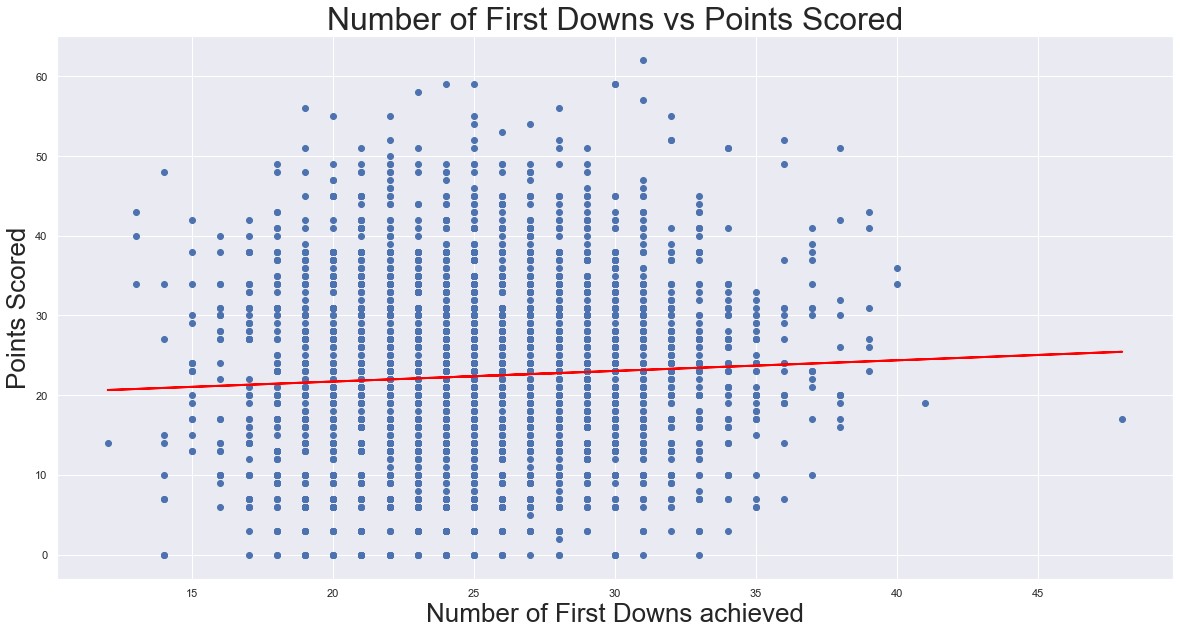

In [345]:
plt.scatter(first_down_df['FirstDown'], first_down_df['PointsScored'])
plt.plot(first_down_df['FirstDown'], ypred, c='red', linewidth=2)
plt.title('Number of First Downs vs Points Scored',fontsize=32)
plt.xlabel('Number of First Downs achieved',fontsize=26)
plt.ylabel('Points Scored',fontsize=26)

#### Based on the red line, the difference between achieving 5 and 40 first downs in a game would give us around 5 points if measured in points scored. The slope is positive, but the model obviously doesn't explain the data set at all. Let's calculate the R-squared to show how bad it is.

In [341]:
reg_var = np.square((ypred - first_down_df['PointsScored'])).sum()
tot_var = np.square((np.full(len(first_down_df['PointsScored']),np.mean([first_down_df['PointsScored']])) - first_down_df['PointsScored'])).sum()

In [342]:
expl_var = tot_var - reg_var
r2 = expl_var / tot_var
print(f'R-squared: {r2}')

R-squared: 0.0031326470028967303


#### Same calculation with sklearn's metrics:

In [331]:
metrics.r2_score(first_down_df['PointsScored'], ypred)

0.003132647002896727

#### As expected the model explained the variance in the data set at 0%, I guess I just really wanted to drive this point home about not having a correlation between the number of first downs achieved and the points scored by a team before I dive deeper to see if it still makes sense to build a model for predicting first downs.

### Data integrity - Is everything recorded correctly apart from the single mistake with the date above?
#### After running the cell below, two lines caught my eye: the 11th and 12th drives from the first game. Here Pittsburgh and Tennessee exchanged touchdowns in the last 2 minutes of the half, but according to the dataset neither achived a first down in the drive while doing so. That is certainly possible (e.g. defensive turnover giving a good field position or a successful deep play from the offense), but it rarely happens twice in a row, plus defensive teams normally try to take away the big play with deep coverages at the end of each half to prevent a (excuse the pun) last minute touchdown. Considering these I checked the particular game from 2009 (thankfully it could be found on YouTube at the time of writing the notebook: https://www.youtube.com/watch?v=IpA3GYAzh68), and found that in reality Pittsburgh achieved 2 first downs before their TD, while Tennessee had 1 before scoring theirs. It seems like the error occurs if the play clock is stopped right after the play, meaning if the next registered "play"  is the end of a quarter, a 2-minute warning before the end of each half, or a timeout by either team. I this scenario, the Steelers achieved a first down right before the 2-minute warning, then another one that was followed by a timeout and then a TD in the next play, while the Titans completed a long pass and achieved a first down that was also followed by a timeout and a score right afterwards in a similar fashion. This way we lost 3 first downs that should have been marked in the dataset.

#### As seen above at the beginning of the notebook, I corrected these instances and changed them to first downs, but kept this cell from before to show the finding.

In [9]:
df_copy = df.copy()
df_copy.loc[:,'FieldGoalResult'].fillna(0, inplace=True)
df_copy.loc[:,'FirstDown'].fillna(0, inplace=True)
df_copy.loc[:,'FirstDown'] = df_copy.loc[:,'FirstDown'].astype(int)
convert_dict_fg = {0:0, 'No Good':0, 'Blocked':0, 'Good':1}
df_copy.loc[:,'FieldGoalResult'] = df_copy.loc[:,'FieldGoalResult'].apply(lambda x: convert_dict_fg[x])
convert_dict_td = {False:0, True:1}
df_copy.loc[:,'Touchdown'] = df_copy.loc[:,'Touchdown'].apply(lambda x: convert_dict_td[x])
df_copy.loc[(df_copy['PlayType']!='Run') & (df_copy['PlayType']!='Pass') & (df_copy['PlayType']!='Sack') & (df_copy['PlayType']!='Spike'),'Yards.Gained'] = 0
drive_fd_df = pd.pivot_table(df_copy, index=['GameID','Drive'], values=['FirstDown','Yards.Gained','Touchdown', 'FieldGoalResult'], aggfunc={'FirstDown':np.sum, 'Yards.Gained':np.sum, 'Touchdown':max, 'FieldGoalResult':max})
drive_fd_df.head(15)

FieldGoalResult  FirstDown  Touchdown  Yards.Gained
GameID     Drive                                                     
2009091000 1                    0          1          0           2.0
           2                    0          1          0           2.0
           3                    0          2          0           2.0
           4                    0          3          0          55.0
           5                    0          1          0          -6.0
           6                    0          4          0          35.0
           7                    0          1          0           3.0
           8                    0          2          0           0.0
           9                    0          3          0          53.0
           10                   0          4          0          45.0
           11                   0          0          1          79.0
           12                   0          0          1          71.0
           13                   0          1          0          23.0
           14                   0          3          0          38.0
           15                   0          1          0           9.0

#### This is the query resulting in all the mislabeled plays. I'm keeping this cell hereas well as it starts with the 3 first downs that I broke down in detail above. With this I managed to rectify the issue in 6548 rows, which basically adds 6548 first downs to the total or in other words an additional 727.55 first downs per season. This also means that originally 1.6% of all plays listed were mislabeled in the 'FirstDown' column.

In [10]:
display_all_columns(
df.loc[(df['ydstogo'] <= df['Yards.Gained']) & 
                           ((df['PlayType'] == 'Pass') | (df['PlayType'] == 'Run')) &
                            (df['sp'] == False) &
                            (df['PenalizedTeam'] != df['posteam']) &
                            (df['FirstDown'] == '0')])

Date      GameID  Drive  qtr  down   time  TimeUnder  TimeSecs  \
67     2009-09-10  2009091000     11    2   2.0  02:08          3    1928.0   
70     2009-09-10  2009091000     11    2   2.0  01:38          2    1898.0   
76     2009-09-10  2009091000     12    2   2.0  01:09          2    1869.0   
82     2009-09-10  2009091000     13    2   2.0  00:35          1    1835.0   
156    2009-09-10  2009091000     23    4   2.0  01:10          2      70.0   
...           ...         ...    ...  ...   ...    ...        ...       ...   
407468 2017-12-31  2017123100     24    4   1.0  02:09          3     129.0   
407511 2017-12-31  2017123101      5    1   3.0  05:30          6    3030.0   
407524 2017-12-31  2017123101      7    1   1.0  01:13          2    2773.0   
407574 2017-12-31  2017123101     17    2   3.0  02:20          3    1940.0   
407603 2017-12-31  2017123101     21    3   1.0  09:34         10    1474.0   

        PlayTimeDiff SideofField  yrdln  yrdline100  ydstogo  ydsnet GoalToGo  \
67               6.0         PIT   21.0        79.0       10      12        0   
70              22.0         PIT   37.0        63.0        6      45        0   
76               6.0         TEN   29.0        71.0       10      57        0   
82               6.0         PIT   32.0        68.0        5      19        0   
156             32.0         TEN   43.0        43.0        7      24        0   
...              ...         ...    ...         ...      ...     ...      ...   
407468          18.0         CAR   36.0        64.0       10      22        0   
407511          38.0         CIN   29.0        71.0        3      16        0   
407524           9.0         CIN   26.0        74.0       10      13        0   
407574          35.0         CIN   27.0        73.0        6      26        0   
407603          37.0         MID   50.0        50.0       10      11        0   

       FirstDown posteam DefensiveTeam  \
67             0     PIT           TEN   
70             0     PIT           TEN   
76             0     TEN           PIT   
82             0     PIT           TEN   
156            0     PIT           TEN   
...          ...     ...           ...   
407468         0     CAR           ATL   
407511         0     CIN           BAL   
407524         0     CIN           BAL   
407574         0     CIN           BAL   
407603         0     BAL           CIN   

                                                     desc  PlayAttempted  \
67      (2:08) (Shotgun) B.Roethlisberger pass short r...           True   
70      (1:38) (No Huddle, Shotgun) B.Roethlisberger p...           True   
76      (1:09) (Shotgun) K.Collins pass deep left to K...           True   
82      (:35) (Shotgun) B.Roethlisberger pass short le...           True   
156     (1:10) (No Huddle, Shotgun) B.Roethlisberger p...           True   
...                                                   ...            ...   
407468  (2:09) (No Huddle, Shotgun) C.Newton pass shor...           True   
407511  (5:30) (No Huddle, Shotgun) A.Dalton pass shor...           True   
407524  (1:13) (No Huddle, Shotgun) A.Dalton pass deep...           True   
407574  (2:20) (No Huddle, Shotgun) A.Dalton pass deep...           True   
407603  (9:34) (Shotgun) J.Flacco pass deep right to M...           True   

        Yards.Gained     sp  Touchdown ExPointResult TwoPointConv DefTwoPoint  \
67              12.0  False      False           NaN          NaN         NaN   
70              29.0  False      False           NaN          NaN         NaN   
76              57.0  False      False           NaN          NaN         NaN   
82              14.0  False      False           NaN          NaN         NaN   
156              9.0  False      False           NaN          NaN         NaN   
...              ...    ...        ...           ...          ...         ...   
407468          11.0  False      False           NaN          NaN         NaN   
407511           9.0  Fal

### Back to first downs and why they matter, even if we just saw how their total amount won't correlate to scoring points and winning games
#### The updated table looks like this. We see each drive of each game and if there was a touchdown or field goal, plus the number of first downs achieved and the yards gained by the offensive team.
##### Note that each drive starts with a first down as the offensive team takes over, so the 1s are essentially 0s in the 'FirstDown' column as the offense didn't manage to gain 10 yards (or scored with less than that). Penalties and negative yardage also affect the number of yards gained and first downs achieved.

In [119]:
df_copy = df.copy()
df_copy.loc[:,'FieldGoalResult'].fillna(0, inplace=True)
df_copy.loc[:,'FirstDown'].fillna(0, inplace=True)
df_copy.loc[:,'FirstDown'] = df_copy.loc[:,'FirstDown'].astype(int)
convert_dict_fg = {0:0, 'No Good':0, 'Blocked':0, 'Good':1}
df_copy.loc[:,'FieldGoalResult'] = df_copy.loc[:,'FieldGoalResult'].apply(lambda x: convert_dict_fg[x])
convert_dict_td = {False:0, True:1}
df_copy.loc[:,'Touchdown'] = df_copy.loc[:,'Touchdown'].apply(lambda x: convert_dict_td[x])
df_copy.loc[(df_copy['PlayType']!='Run') & (df_copy['PlayType']!='Pass') & (df_copy['PlayType']!='Sack') & (df_copy['PlayType']!='Spike'),'Yards.Gained'] = 0
drive_fd_df = pd.pivot_table(df_copy, index=['GameID','Drive'], values=['FirstDown','Yards.Gained','Touchdown', 'FieldGoalResult'], aggfunc={'FirstDown':np.sum, 'Yards.Gained':np.sum, 'Touchdown':max, 'FieldGoalResult':max})
drive_fd_df.loc[drive_fd_df['Touchdown']==0,'AvgYardsPerFirstDown'] = [round(yards/fds,0) if fds!=0 else yards for yards,fds in zip(drive_fd_df.loc[drive_fd_df['Touchdown']==0,'Yards.Gained'],drive_fd_df.loc[drive_fd_df['Touchdown']==0,'FirstDown'])]
drive_fd_df.loc[drive_fd_df['Touchdown']==1,'AvgYardsPerFirstDown'] = [round(yards/fds,0) if fds!=0 else yards for yards,fds in zip(drive_fd_df.loc[drive_fd_df['Touchdown']==1,'Yards.Gained'],drive_fd_df.loc[drive_fd_df['Touchdown']==1,'FirstDown'])]
drive_fd_df.head(15)

FieldGoalResult  FirstDown  Touchdown  Yards.Gained  \
GameID     Drive                                                        
2009091000 1                    0          1          0           2.0   
           2                    0          1          0           2.0   
           3                    0          2          0           2.0   
           4                    0          3          0          55.0   
           5                    0          1          0          -6.0   
           6                    0          4          0          35.0   
           7                    0          1          0           3.0   
           8                    0          2          0           0.0   
           9                    0          3          0          53.0   
           10                   0          4          0          45.0   
           11                   0          2          1          79.0   
           12                   0          1          1          71.0   
           13                   0          2          0          23.0   
           14                   0          3          0          38.0   
           15                   0          1          0           9.0   

                  AvgYardsPerFirstDown  
GameID     Drive                        
2009091000 1                       2.0  
           2                       2.0  
           3                       1.0  
           4                      18.0  
           5                      -6.0  
           6                       9.0  
           7                       3.0  
           8                       0.0  
           9                      18.0  
           10                     11.0  
           11                     40.0  
           12                     71.0  
           13                     12.0  
           14                     13.0  
           15                      9.0

#### Let's take look at the TD drives and if teams need first downs to score at all.

In [123]:
td_drives = pd.DataFrame({'Number of First Downs':[drive_fd_df.loc[drive_fd_df['Touchdown']==1,'FirstDown'].mean(), drive_fd_df.loc[drive_fd_df['Touchdown']==1,'FirstDown'].median(), drive_fd_df.loc[drive_fd_df['Touchdown']==1,'FirstDown'].std()],
                        'Average Yards Gained per First Downs':[drive_fd_df.loc[drive_fd_df['Touchdown']==1,'AvgYardsPerFirstDown'].mean(), drive_fd_df.loc[drive_fd_df['Touchdown']==1,'AvgYardsPerFirstDown'].median(), drive_fd_df.loc[drive_fd_df['Touchdown']==1,'AvgYardsPerFirstDown'].std()]},
                        index = ['Mean', 'Median','STD'])
td_drives

Number of First Downs  Average Yards Gained per First Downs
Mean                 2.733345                             25.016997
Median               3.000000                             20.000000
STD                  1.790456                             18.440306

#### Let's check the distribution on a boxplot.

Text(0.5, 1.0, 'Average Yards Gained per First Down on TD Drives')

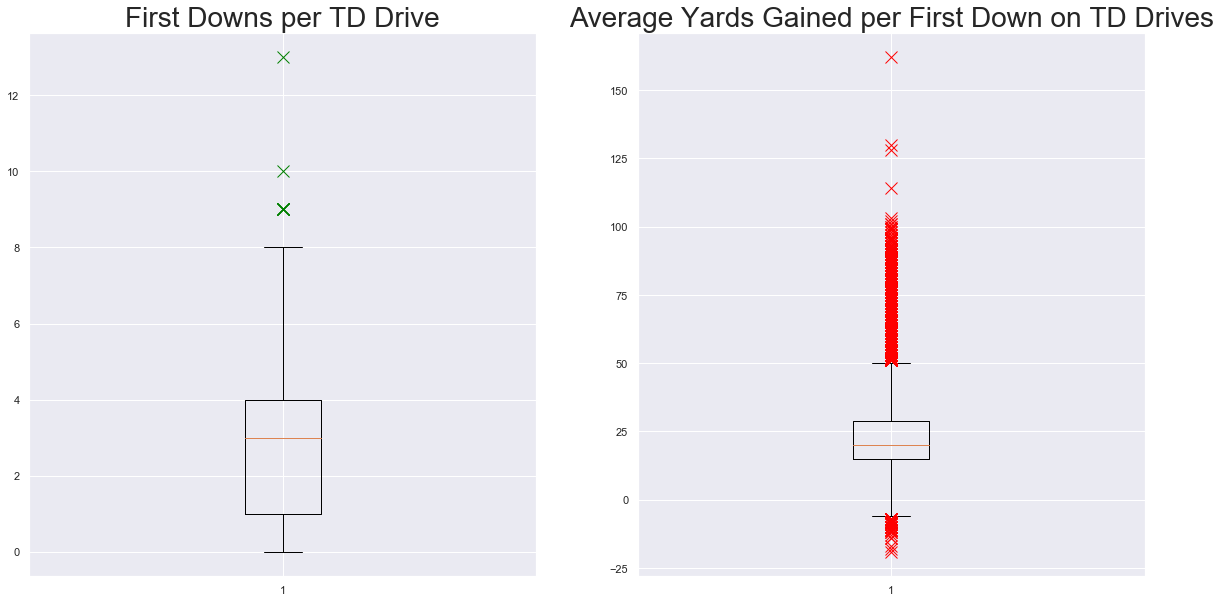

In [124]:
fig, axs = plt.subplots(1, 2)

flierprops1 = dict(marker='x', markerfacecolor='green', markersize=12,
                  linestyle='none', markeredgecolor='green')
axs[0].boxplot(drive_fd_df.loc[drive_fd_df['Touchdown']==1,'FirstDown'], flierprops=flierprops1)
axs[0].set_title('First Downs per TD Drive',fontsize=28)

flierprops2 = dict(marker='x', markerfacecolor='red', markersize=12,
                  linestyle='none', markeredgecolor='red')
axs[1].boxplot(drive_fd_df.loc[drive_fd_df['Touchdown']==1,'AvgYardsPerFirstDown'], flierprops=flierprops2)
axs[1].set_title('Average Yards Gained per First Down on TD Drives',fontsize=28)

#### Based on the distribution of the values, we can surely say that teams don't need many first downs to put 6 points on the board. They basically need to achieve between 1 and 4, with 3 first downs being the median and the rounded average as well. This tells us that in a TD drive there are normally some big plays, so instead of advancing with 3-5 yard gains and therefore achiving 5-8 first downs (dependent on starting field position), teams will most likely get a couple of big plays going with more yardage.
#### The average yards gained per first down plot supports this idea, putting the median at 20 yards which in fact could account for 2 first downs if they gained yardage in different chunks, while the average is even higher at 25 yards. We have to note that the standard deviation is very high in the series (18.44), so take this one with a grain of salt though.
#### Now let's have a look at the number of first downs achieved, but separating touchdown, field goal, and non-scoring drives.

Text(0.5, 1.0, 'First Downs per Non-Scoring Drive')

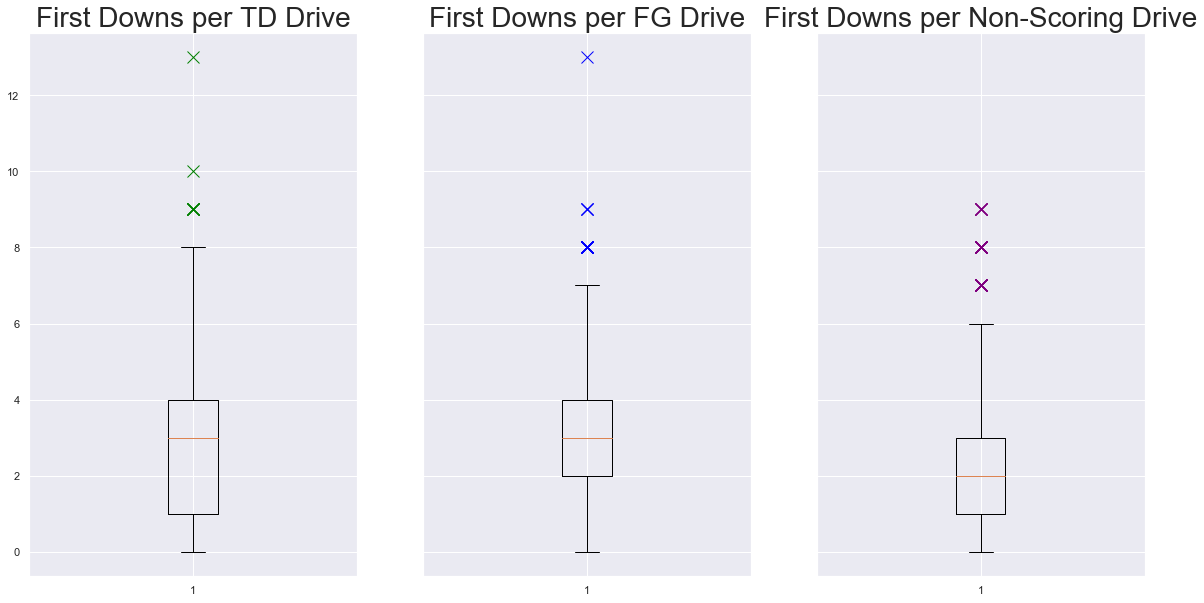

In [130]:
fig, axs = plt.subplots(1, 3, sharey=True)

flierprops1 = dict(marker='x', markerfacecolor='green', markersize=12,
                  linestyle='none', markeredgecolor='green')
axs[0].boxplot(drive_fd_df.loc[drive_fd_df['Touchdown']==1,'FirstDown'], flierprops=flierprops1)
axs[0].set_title('First Downs per TD Drive',fontsize=28)

flierprops2 = dict(marker='x', markerfacecolor='blue', markersize=12,
                  linestyle='none', markeredgecolor='blue')
axs[1].boxplot(drive_fd_df.loc[drive_fd_df['FieldGoalResult']==1,'FirstDown'], flierprops=flierprops2)
axs[1].set_title('First Downs per FG Drive',fontsize=28)

flierprops3 = dict(marker='x', markerfacecolor='purple', markersize=12,
                  linestyle='none', markeredgecolor='purple')
axs[2].boxplot(drive_fd_df.loc[(drive_fd_df['Touchdown']==0) & (drive_fd_df['FieldGoalResult']==0),'FirstDown'], flierprops=flierprops3)
axs[2].set_title('First Downs per Non-Scoring Drive',fontsize=28)

#### It does look like in most cases, that 1 additional first down is going to be the difference between scoring and giving the ball back to the opponent without putting anything on the board. Notice that non-scoring drives are shorter and have less first downs in the 3rd quartile and the maximum as well.<br>
### It's not about how many you can achieve, it's about getting them *when* it matters - Situational football
#### There are situations in football, when the goal is specifically to get one more first down. When the first down marker is only a yard away, even if the opponent knows that the offense will try to force a run for a yard, there is still a good chance of getting it, simply because of the short distance the player needs to cover. Another obvious example is when at the end of a close game, the winning team's offense tries to get a first down, so they can run the game clock down without doing anything else. Teams can only call 3 timeouts per half, so the other team can't rely on timeouts forever to stretch the game any more.

#### Before moving on to building a model, I wanted to check one more thing and that is the 'ydstogo' column. This will show how likely it is to convert on a first down based on the distance to the marker. I'll filter the original df to get rid of the plays where teams attempted a field goal or scored a touchdown, and the rows without actual plays called as well (e.g. timeouts as 'NaN' in 'FirstDown' column).

Text(0.5, 1.0, 'Short (3-0) yardage needed')

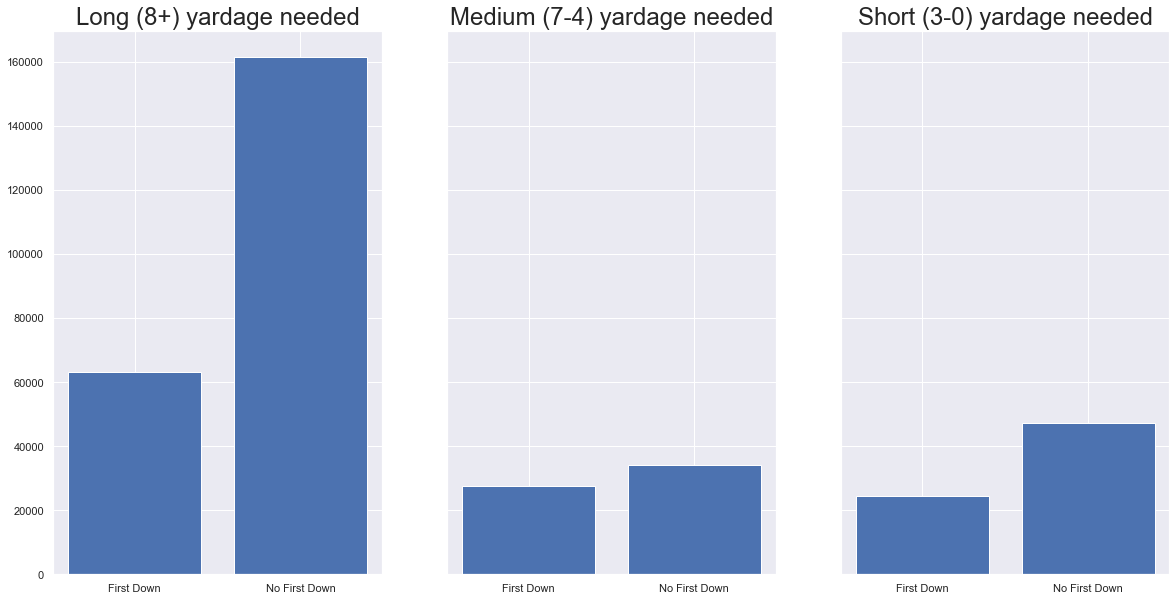

In [171]:
non_scoring_df = df.loc[(df['Touchdown']!=True) & (df['FieldGoalResult']!='Good') & (df['FieldGoalResult']!='No Good') & (df['FieldGoalResult']!='Blocked')]

long_yds = pd.Series([fd for fd in non_scoring_df.loc[non_scoring_df['ydstogo']>=8, 'FirstDown'] if str(fd)!='nan'])
med_yds = pd.Series([fd for fd in non_scoring_df.loc[(non_scoring_df['ydstogo']<=7) & (non_scoring_df['ydstogo']>=4), 'FirstDown'] if str(fd)!='nan'])
short_yds = pd.Series([fd for fd in non_scoring_df.loc[non_scoring_df['ydstogo']<=3, 'FirstDown'] if str(fd)!='nan'])
xaxis = ['First Down', 'No First Down']

fig, axs = plt.subplots(1, 3, sharey=True)

axs[0].bar(xaxis,[long_yds[long_yds=='1'].count(),long_yds[long_yds=='0'].count()])
axs[0].set_title('Long (8+) yardage needed',fontsize=24)

axs[1].bar(xaxis,[med_yds[med_yds=='1'].count(),med_yds[med_yds=='0'].count()])
axs[1].set_title('Medium (7-4) yardage needed',fontsize=24)

axs[2].bar(xaxis,[short_yds[short_yds=='1'].count(),short_yds[short_yds=='0'].count()])
axs[2].set_title('Short (3-0) yardage needed',fontsize=24)

In [176]:
conversion_df = pd.DataFrame({'Long yardage':[long_yds[long_yds=='1'].count(),long_yds[long_yds=='0'].count(),(long_yds[long_yds=='1'].count()/long_yds.count())*100],
                             'Medium yardage':[med_yds[med_yds=='1'].count(),med_yds[med_yds=='0'].count(),(med_yds[med_yds=='1'].count()/med_yds.count())*100],
                             'Short yardage':[short_yds[short_yds=='1'].count(),short_yds[short_yds=='0'].count(),(short_yds[short_yds=='1'].count()/short_yds.count())*100]},
                            index=['First Down', 'No First Down', 'Conversion rate (%)'])
conversion_df

Long yardage  Medium yardage  Short yardage
First Down            63154.00000     27400.00000   24483.000000
No First Down        161536.00000     34244.00000   47160.000000
Conversion rate (%)      28.10717        44.44877      34.173611

#### Interestingly getting a first down won't be easier if a team is closer to the marker. It surely is the hardest when the distance is larger than 7 yards, but inside that going for medium yardage (7-4) has a whopping 10% higher conversion rate than trying from short (3 or less). A possible explanation could be that defenses are focused on the first down line, making sure the offense can't get an easy short yardage play to cross it. Another reason might be the classic run - pass combo for the first two downs that coaches still use as a go-to in today's league as well. If the first run play gains 3-4 yards, than the pass will only need to travel another 6-7 to achieve a first down, which is not that much to ask in today's (or more like the last 8-10 years') pass-heavy league.
#### Let's see the same plot and table for 3rd down plays only, when situational football is at its best.

Text(0.5, 1.0, 'Short (3-0) yardage needed')

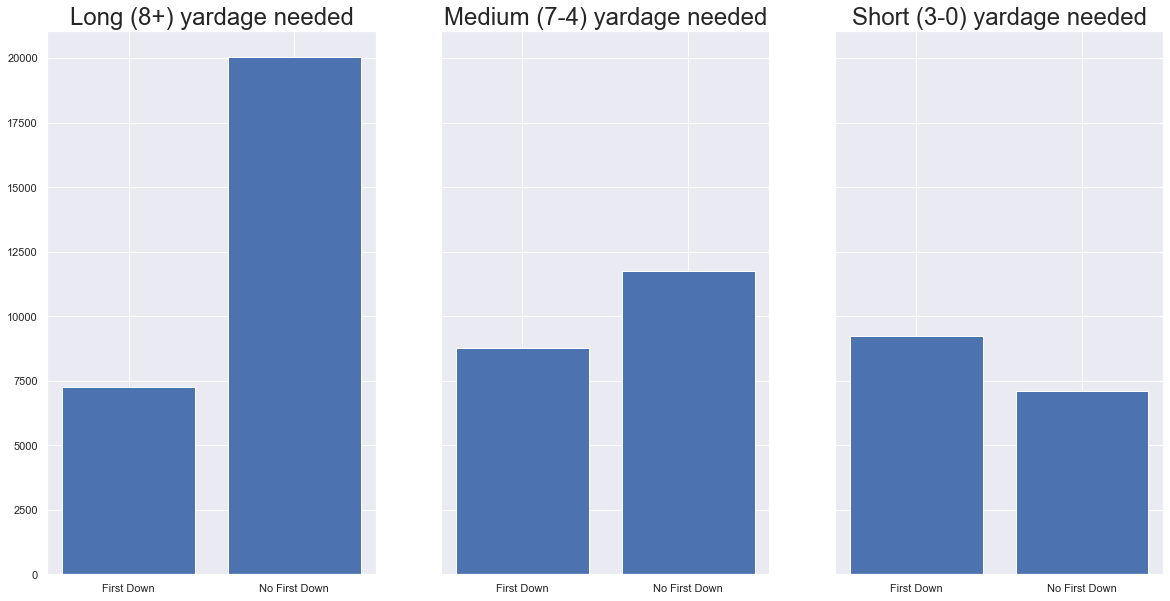

In [178]:
non_scoring_3rd_df = df.loc[(df['Touchdown']!=True) & (df['FieldGoalResult']!='Good') & (df['FieldGoalResult']!='No Good') & (df['down']==3)]

long_yds_3rd = pd.Series([fd for fd in non_scoring_3rd_df.loc[non_scoring_3rd_df['ydstogo']>=8, 'FirstDown'] if str(fd)!='nan'])
med_yds_3rd = pd.Series([fd for fd in non_scoring_3rd_df.loc[(non_scoring_3rd_df['ydstogo']<=7) & (non_scoring_3rd_df['ydstogo']>=4), 'FirstDown'] if str(fd)!='nan'])
short_yds_3rd = pd.Series([fd for fd in non_scoring_3rd_df.loc[non_scoring_3rd_df['ydstogo']<=3, 'FirstDown'] if str(fd)!='nan'])
xaxis = ['First Down', 'No First Down']

fig, axs = plt.subplots(1, 3, sharey=True)

axs[0].bar(xaxis,[long_yds_3rd[long_yds_3rd=='1'].count(),long_yds_3rd[long_yds_3rd=='0'].count()])
axs[0].set_title('Long (8+) yardage needed',fontsize=24)

axs[1].bar(xaxis,[med_yds_3rd[med_yds_3rd=='1'].count(),med_yds_3rd[med_yds_3rd=='0'].count()])
axs[1].set_title('Medium (7-4) yardage needed',fontsize=24)

axs[2].bar(xaxis,[short_yds_3rd[short_yds_3rd=='1'].count(),short_yds_3rd[short_yds_3rd=='0'].count()])
axs[2].set_title('Short (3-0) yardage needed',fontsize=24)

In [179]:
conversion_3rd_df = pd.DataFrame({'Long yardage':[long_yds_3rd[long_yds_3rd=='1'].count(),long_yds_3rd[long_yds_3rd=='0'].count(),(long_yds_3rd[long_yds_3rd=='1'].count()/long_yds_3rd.count())*100],
                             'Medium yardage':[med_yds_3rd[med_yds_3rd=='1'].count(),med_yds_3rd[med_yds_3rd=='0'].count(),(med_yds_3rd[med_yds_3rd=='1'].count()/med_yds_3rd.count())*100],
                             'Short yardage':[short_yds_3rd[short_yds_3rd=='1'].count(),short_yds_3rd[short_yds_3rd=='0'].count(),(short_yds_3rd[short_yds_3rd=='1'].count()/short_yds_3rd.count())*100]},
                            index=['First Down', 'No First Down', 'Conversion rate (%)'])
conversion_3rd_df

Long yardage  Medium yardage  Short yardage
First Down            7241.000000     8749.000000    9229.000000
No First Down        20054.000000    11736.000000    7112.000000
Conversion rate (%)     26.528668       42.709299      56.477572

#### And here we see the expected (?) increasing chance of crossing the line of the first down marker as teams get closer to it, which goes up by 16% and 14% from long to medium and medium to short yardage respectively. If we look at the two plots, there is a plausible argument for the sudden jump for the conversion rate when we only consider 3rd downs in short yardage situations. Even if intuitively we might think that the bigger the pressure the harder it is to execute the play properly for the offensive players, there is still an undeniable difference in difficulty when it comes to plays designed to go for more than 10 yards and the ones for 2 or 3. Coaches like to call a big play when it's 2nd and short as even if they can't go downfield with a successful pass play, there is still another opportunity to just convert on the first down with their 3rd try with a much easier play. And as the numbers show, they tend take advantage of that opportunity and get the first down in more than 56% of the cases.
### These and the above mentioned specific situations are where a predictive model based on the parameters of the play could really help to get the desired first down.

### Features of the model
#### The add_datepart() function is another useful one from the fastai library (and it will be followed by others), it can never hurt to see if there is a correlation between an aspect of the date of the event and the dependent variable.
#### I will also add a new feature to show if there was a timeout by either team right before the current play, as timeouts are important when it comes to play calling. Since this value will be False for most of the rows in the dataframe, I don't expect much from it, but it's worth checking.

In [216]:
add_datepart(X, 'Date')

In [217]:
display_all_columns(X.head())

GameID  Drive  qtr  down   time  TimeUnder  TimeSecs  PlayTimeDiff  \
0  2009091000      1    1   NaN  15:00         15    3600.0           0.0   
1  2009091000      1    1   1.0  14:53         15    3593.0           7.0   
2  2009091000      1    1   2.0  14:16         15    3556.0          37.0   
3  2009091000      1    1   3.0  13:35         14    3515.0          41.0   
4  2009091000      1    1   4.0  13:27         14    3507.0           8.0   

  SideofField  yrdln  yrdline100  ydstogo GoalToGo  FirstDown posteam  \
0         TEN   30.0        30.0        0        0          0     PIT   
1         PIT   42.0        58.0       10        0          0     PIT   
2         PIT   47.0        53.0        5        0          0     PIT   
3         PIT   44.0        56.0        8        0          0     PIT   
4         PIT   44.0        56.0        8        0          1     PIT   

  DefensiveTeam  PlayAttempted PlayType            Passer   Passer_ID  \
0           TEN           True  Kickoff               NaN        None   
1           TEN           True     Pass  B.Roethlisberger  00-0022924   
2           TEN           True      Run               NaN        None   
3           TEN           True     Pass  B.Roethlisberger  00-0022924   
4           TEN           True     Punt               NaN        None   

   PassAttempt PassLocation    Rusher   Rusher_ID  RushAttempt RunLocation  \
0        False          NaN       NaN        None        False         NaN   
1         True         left       NaN        None        False         NaN   
2        False          NaN  W.Parker  00-0022250         True       right   
3         True        right       NaN        None        False         NaN   
4        False          NaN       NaN        None        False         NaN   

  RunGap  PosTeamScore  DefTeamScore  ScoreDiff  AbsScoreDiff HomeTeam  \
0    NaN           0.0           0.0        0.0           0.0      PIT   
1    NaN           0.0           0.0        0.0           0.0      PIT   
2    end           0.0           0.0        0.0           0.0      PIT   
3    NaN           0.0           0.0        0.0           0.0      PIT   
4    NaN           0.0           0.0        0.0           0.0      PIT   

  AwayTeam  Timeout_Indicator Timeout_Team  posteam_timeouts_pre  \
0      TEN              False         None                     3   
1      TEN              False         None                     3   
2      TEN              False         None                     3   
3      TEN              False         None                     3   
4      TEN              False         None                     3   

   HomeTimeouts_Remaining_Pre  AwayTimeouts_Remaining_Pre  \
0                           3                           3   
1                           3                           3   
2                           3                           3   
3                           3                           3   
4                           3                           3   

   HomeTimeouts_Remaining_Post  AwayTimeouts_Remaining_Post  Season  Year  \
0                            3                            3    2009  2009   
1                            3                            3    2009  2009   
2                            3                            3    2009  2009   
3                            3                            3    2009  2009   
4                            3                            3    2009  2009   

   Elapsed  Month  Week  Day  Dayofweek  Dayofyear  Is_month_end  \
0        0      9    37   10          3        253         False   
1        0      9    37   10          3        253         False   
2        0      9    37   10          3        253         False   
3        0      9    37   10          3        253         False   
4        0      9    37   10          3        253         False   

   Is_month_start  Is_quarter_end  Is_quarter_start  Is_year_end  \
0           False           False   

In [218]:
X['timeout_before_play'] = [False] + [True if X.loc[i-1,'PlayType']=='Timeout' else False for i in range(1,len(X['PlayType']))]
display_all(X.head(200))

GameID  Drive  qtr  down   time  TimeUnder  TimeSecs  PlayTimeDiff  \
0    2009091000      1    1   NaN  15:00         15    3600.0           0.0   
1    2009091000      1    1   1.0  14:53         15    3593.0           7.0   
2    2009091000      1    1   2.0  14:16         15    3556.0          37.0   
3    2009091000      1    1   3.0  13:35         14    3515.0          41.0   
4    2009091000      1    1   4.0  13:27         14    3507.0           8.0   
5    2009091000      2    1   1.0  13:16         14    3496.0          11.0   
6    2009091000      2    1   2.0  12:40         13    3460.0          36.0   
7    2009091000      2    1   3.0  12:11         13    3431.0          29.0   
8    2009091000      2    1   4.0  11:34         12    3394.0          37.0   
9    2009091000      3    1   1.0  11:24         12    3384.0          10.0   
10   2009091000      3    1   2.0  10:48         11    3348.0          36.0   
11   2009091000      3    1   1.0  10:21         11    3321.0          27.0   
12   2009091000      3    1   2.0  09:43         10    3283.0          38.0   
13   2009091000      3    1   3.0  09:01         10    3241.0          42.0   
14   2009091000      3    1   4.0  08:25          9    3205.0          36.0   
15   2009091000      4    1   1.0  08:20          9    3200.0           5.0   
16   2009091000      4    1   1.0  07:57          8    3177.0          23.0   
17   2009091000      4    1   1.0  07:24          8    3144.0          33.0   
18   2009091000      4    1   2.0  06:57          7    3117.0          27.0   
19   2009091000      4    1   3.0  06:52          7    3112.0           5.0   
20   2009091000      4    1   4.0  06:48          7    3108.0           4.0   
21   2009091000      5    1   1.0  06:44          7    3104.0           4.0   
22   2009091000      5    1   2.0  06:09          7    3069.0          35.0   
23   2009091000      5    1   3.0  05:27          6    3027.0          42.0   
24   2009091000      5    1   4.0  05:02          6    3002.0          25.0   
25   2009091000      6    1   1.0  04:49          5    2989.0          13.0   
26   2009091000      6    1   1.0  04:27          5    2967.0          22.0   
27   2009091000      6    1   1.0  04:07          5    2947.0          20.0   
28   2009091000      6    1   2.0  03:45          4    2925.0          22.0   
29   2009091000      6    1   3.0  03:06          4    2886.0          39.0   
30   2009091000      6    1   1.0  02:28          3    2848.0          38.0   
31   2009091000      6    1   2.0  01:51          2    2811.0          37.0   
32   2009091000      7    1   1.0  01:38          2    2798.0          13.0   
33   2009091000      7    1   2.0  00:57          1    2757.0          41.0   
34   2009091000      7    1   3.0  00:12          1    2712.0          45.0   
35   2009091000      8    1   1.0  00:06          1    2706.0           6.0   
36   2009091000      8    1   NaN  00:00          0    2700.0           6.0   
37   2009091000      8    2   2.0  15:00         15    2700.0           0.0   
38   2009091000      8    2   1.0  14:22         15    2662.0          38.0   
39   2009091000      8    2   2.0  13:49         14    2629.0          33.0   
40   2009091000      8    2   3.0  13:44         14    2624.0           5.0   
41   2009091000      8    2   4.0  13:13         14    2593.0          31.0   
42   2009091000      9    2   1.0  13:04         14    2584.0           9.0   
43   2009091000      9    2   2.0  12:23         13    2543.0          41.0   
44   2009091000      9    2   3.0  11:39         12    2499.0          44.0   
45   2009091000      9    2   1.0  10:59         11    2459.0          40.0   
46   2009091000      9    2   2.0  10:19         11    2419.0          40.0   
47   2009091000      9    2   2.0  09:54         10    2394.0          25.0   
48   2009091000      9    2   2.0  09:43         10    2383.0          11.0   
49   2009091000      9    2   1.0  08:59          9    2339

#### Filling in the gaps
#### As I mentioned before, sometimes it's reasonable to fill in null values logically, if I can keep myself honest and avoid giving any additional information by it that otherwise couldn't have been derived from the data set. Let's see the columns with missing values.

In [219]:
na_column_dict_X = {column:value for column,value in zip(X.columns,X.isnull().any())}
na_columns_X = [col for (col,value) in na_column_dict_X.items() if value==True]
na_columns_X

['down',
 'time',
 'TimeSecs',
 'PlayTimeDiff',
 'SideofField',
 'yrdln',
 'yrdline100',
 'GoalToGo',
 'posteam',
 'DefensiveTeam',
 'Passer',
 'PassLocation',
 'Rusher',
 'RunLocation',
 'RunGap',
 'PosTeamScore',
 'DefTeamScore',
 'ScoreDiff',
 'AbsScoreDiff']

#### There's no need to worry about columns with string data type, as mentioned before random forests are quite good at handling missing values there. I'll convert them into category type with train_cats() that will actually translate them to numeric values, and the NaNs will just mean another category for the model.
#### The gaps in the numeric columns on the other hand need to be filled in. I'll separate the dependent variable and check for any missing values with proc_df(). It will fill in all NaNs with the median value of the column.

In [238]:
train_cats(X)
X, y, nas = proc_df(X,'FirstDown')
nas

{'down': 2.0,
 'TimeSecs': 1800.0,
 'PlayTimeDiff': 17.0,
 'yrdln': 30.0,
 'yrdline100': 49.0,
 'PosTeamScore': 7.0,
 'DefTeamScore': 10.0,
 'ScoreDiff': 0.0,
 'AbsScoreDiff': 7.0}

#### Since football is changing all the time, and the purpose of this model is to predict the outcome of plays called in the future, I will split the data into training, validation, and test sets based on the indexing as the dataframe is ordered by the 'date'. There is no point in randomising the samples here as we wish to keep the chronological order to create predictions for the last 20% of plays when the model is ready.

In [239]:
X_train = X[:int(round(len(X)*0.6,0))]
X_valid = X[int(round(len(X)*0.6,0)):int(round(len(X)*0.8,0))]
X_test = X[int(round(len(X)*0.8,0)):]
y_train = y[:int(round(len(y)*0.6,0))]
y_valid = y[int(round(len(y)*0.6,0)):int(round(len(X)*0.8,0))]
y_test = y[int(round(len(y)*0.8,0)):]

In [240]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((244613, 63), (244613,), (81537, 63), (81537,), (81538, 63), (81538,))

#### Setting the sample size to 50000 will help with the training speed, while still keeping enough data to consider the results significant.

In [241]:
set_rf_samples(50000)

#### Let's see what 20 trees would give us with the default settings of the random forest classifier from the Scikit-learn library.
#### The third value is the score on the training set and the last one is showing the success rate on the validation set.

In [242]:
m = RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state = 42)
m.fit(X_train, y_train)
y_pred = m.predict(X_valid)
print_score(m)

[0.3631328082452283,
 0.44878223771778447,
 0.8681345635759342,
 0.798594503109018]

#### Not too bad! Almost 80% on the validation set without any kind of optimisation. Now let's see if we can improve it.
#### Three of the hyperparameters I normally start with are 'n_estimators', 'min_samples_leaf', and 'max_features' as this way I can check if accuracy can be improved without losing sight of having a model that generalises well.

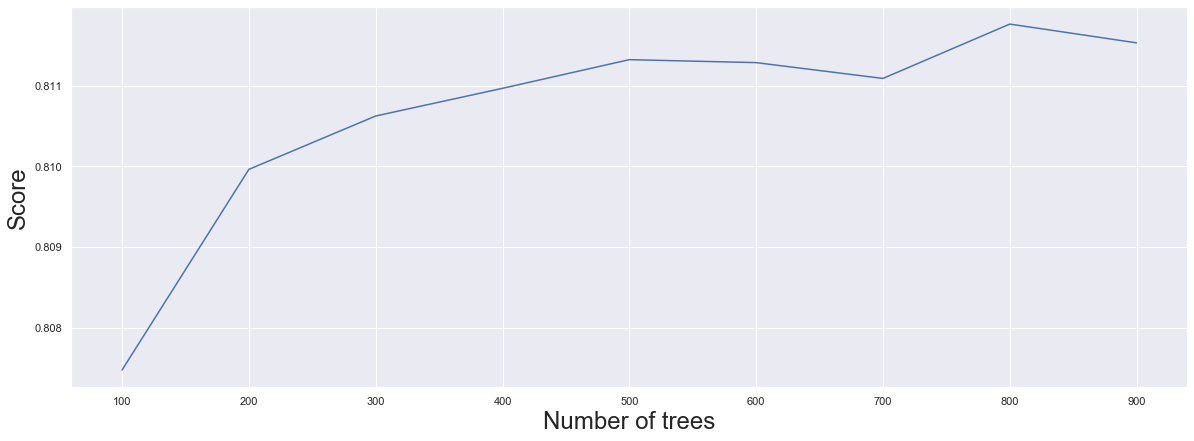

In [285]:
plt.plot([x for x in range(100,1000,100)], 
         [print_score(RandomForestClassifier(n_estimators=x, n_jobs=-1, random_state = 42).fit(X_train, y_train))[3] for x in range(100,1000,100)])
plt.xlabel('Number of trees',fontsize=24)
plt.ylabel('Score',fontsize=24)
plt.rcParams["figure.figsize"] = (20,7)

Text(0, 0.5, 'Score')

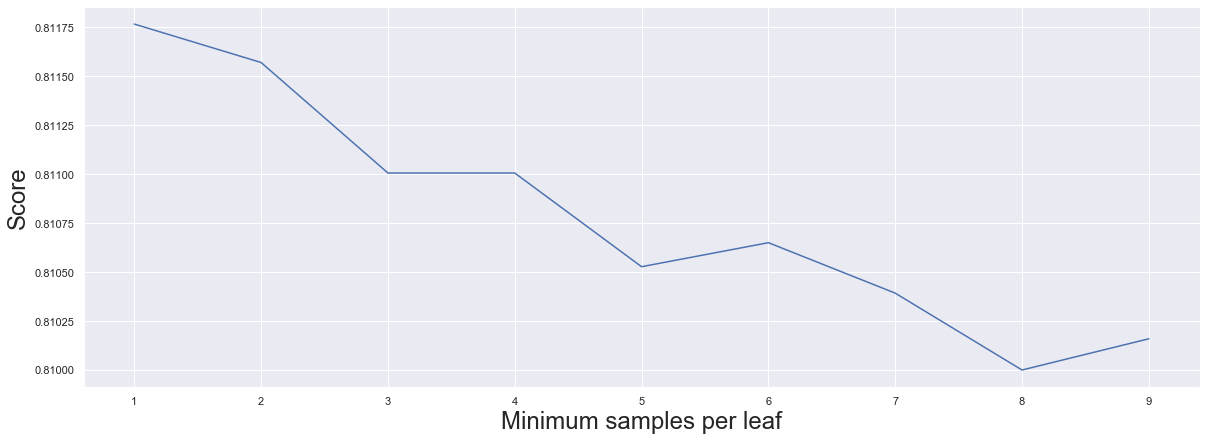

In [281]:
plt.plot([x for x in range(1,10)], 
         [print_score(RandomForestClassifier(n_estimators=800, min_samples_leaf=x, n_jobs=-1, random_state = 42).fit(X_train, y_train))[3] for x in range(1,10)])
plt.xlabel('Minimum samples per leaf',fontsize=24)
plt.ylabel('Score',fontsize=24)

Text(0, 0.5, 'Score')

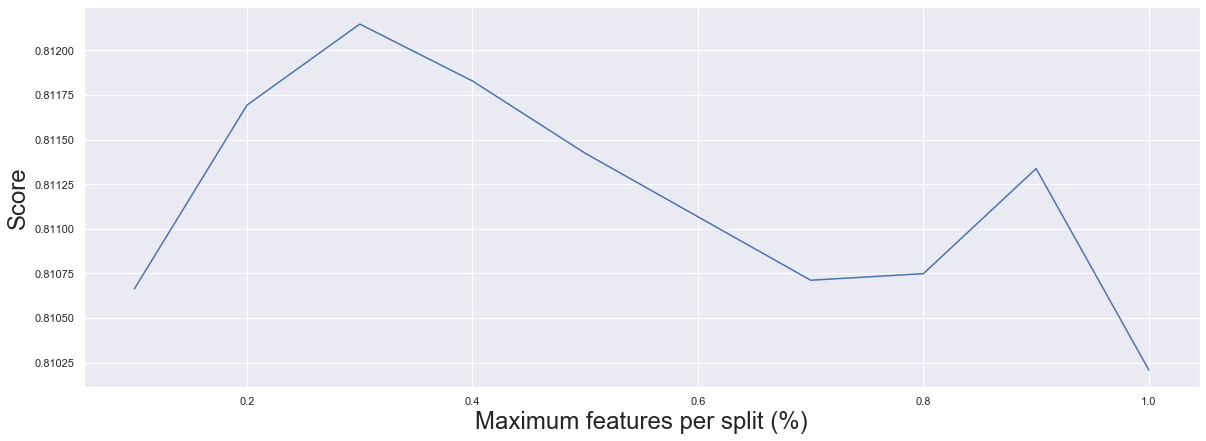

In [282]:
plt.plot([x for x in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]], 
         [print_score(RandomForestClassifier(n_estimators=800, min_samples_leaf=1, max_features=x, n_jobs=-1, random_state = 42).fit(X_train, y_train))[3] for x in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]])
plt.xlabel('Maximum features per split (%)',fontsize=24)
plt.ylabel('Score',fontsize=24)

#### Based on the plots above, this is the optimised model for the validation set.

In [283]:
m = RandomForestClassifier(n_estimators=800, min_samples_leaf=1, max_features=0.3, n_jobs=-1, random_state = 42)
m.fit(X_train, y_train)
y_pred = m.predict(X_valid)
print_score(m)

[0.336420534853462,
 0.43342054310218925,
 0.8868212237289106,
 0.8121466328170033]

#### I'll set the 'min_samples_leaf' parameter to 2 to help it generalise better.

In [284]:
m = RandomForestClassifier(n_estimators=800, min_samples_leaf=2, max_features=0.3, n_jobs=-1, random_state = 42)
m.fit(X_train, y_train)
y_pred = m.predict(X_valid)
print_score(m)

[0.3584474659640177,
 0.4325708091589275,
 0.8715154141439744,
 0.8128824950635908]

#### We've managed to improve by 1,4% on the validation set, it's not much, but still an improvement.<br>Note that since the difference between running the classifier with 100 and 800 trees was minimal, executing these cells could be sped up by setting 'n_estimators' to a lower number.
#### Let's see the features of the model.

Text(0.5, 1.0, 'Feature importance - Bar chart')

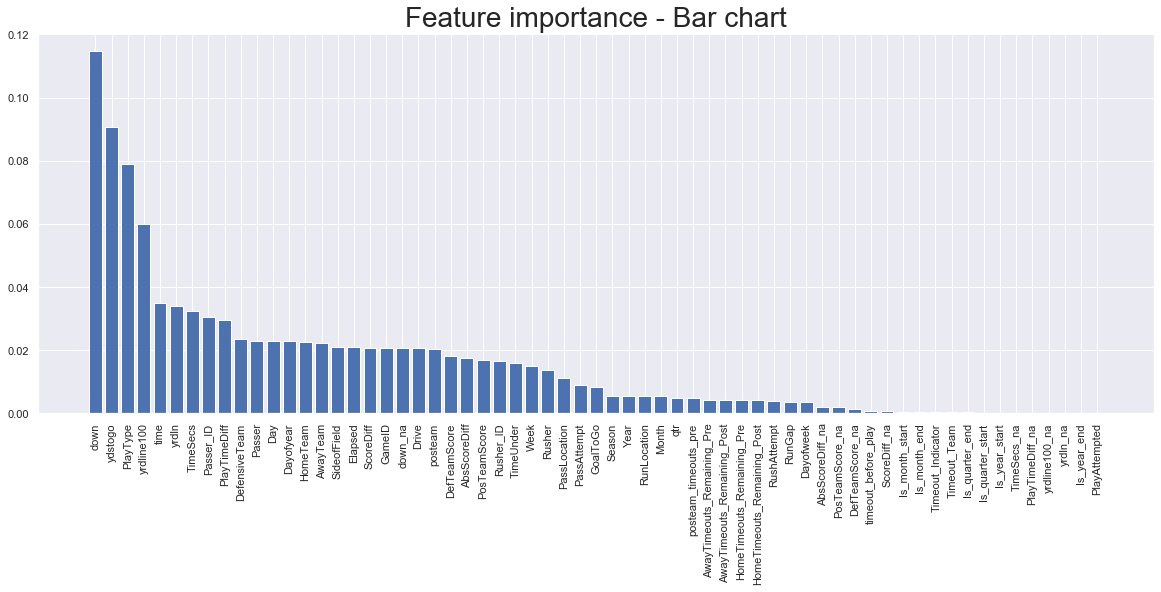

In [295]:
feat_imp_df = rf_feat_importance(m, X_train)
plt.bar(feat_imp_df['cols'], feat_imp_df['imp'])
plt.xticks(rotation=90)
plt.title('Feature importance - Bar chart',fontsize=28)

Text(0.5, 1.0, 'Feature importance - Line chart')

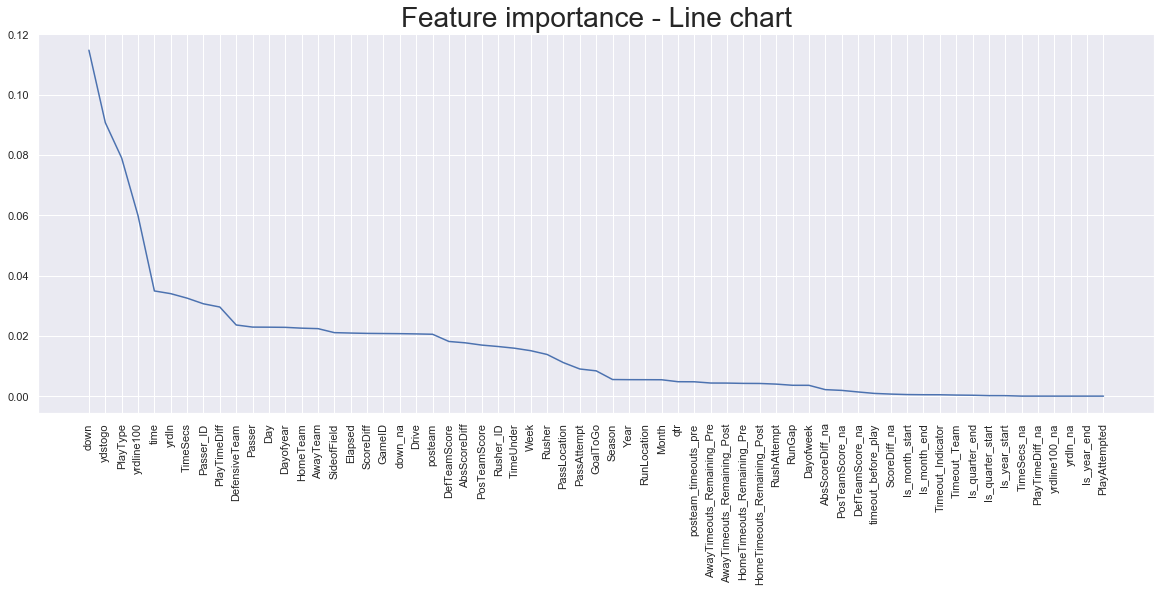

In [296]:
plt.plot(feat_imp_df['cols'], feat_imp_df['imp'])
plt.xticks(rotation=90)
plt.title('Feature importance - Line chart',fontsize=28)

#### Interestingly 'down' and 'ydstogo' came back as the two most important features, and this is something I have encountered in the analysis above while plotting the conversion rates based on 'ydstogo' categories (short, medium, and long yardage situations) and then doing the same separately for 3rd downs. The big difference in conversion rates implied that the features could prove to be important and actually came in first and second place.
#### Let's check the score for the test set and if the model generalises well enough to stay around 80%.

In [311]:
def print_test_score(m):
    res = [rmse(m.predict(X_train), y_train),
           rmse(m.predict(X_test), y_test),
           m.score(X_train, y_train), m.score(X_test, y_test)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    return res

In [312]:
m = RandomForestClassifier(n_estimators=800, min_samples_leaf=1, max_features=0.3, n_jobs=-1, random_state = 42)
m.fit(X_train, y_train)
y_pred_test = m.predict(X_test)
print_test_score(m)

[0.336420534853462, 0.4433631964725559, 0.8868212237289106, 0.8034290760136378]

In [313]:
m = RandomForestClassifier(n_estimators=800, min_samples_leaf=2, max_features=0.3, n_jobs=-1, random_state = 42)
m.fit(X_train, y_train)
y_pred_test = m.predict(X_test)
print_test_score(m)

[0.3584474659640177,
 0.4410473888208111,
 0.8715154141439744,
 0.8054772008143443]

#### We managed to pretty much reproduce the results on the test set (less than 1% drop in the score), which is great in terms of how stable the model is. This shows that even though it could not get up to an accuracy of say 90%, it generalises well to get results over 80% consistently and would only get better with new seasons added to the traning data.
#### I will select the 20 most important features, check the final score on the test set and how the importance ratio changed.

In [314]:
def print_test_score_top20(m):
    res = [rmse(m.predict(X_train[top_20_feats]), y_train),
           rmse(m.predict(X_test[top_20_feats]), y_test),
           m.score(X_train[top_20_feats], y_train), m.score(X_test[top_20_feats], y_test)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    return res

In [315]:
top_20_feats = list(feat_imp_df['cols'][:20])
m = RandomForestClassifier(n_estimators=800, min_samples_leaf=2, max_features=0.3, n_jobs=-1, random_state = 42)
m.fit(X_train[top_20_feats], y_train)
y_pred_test = m.predict(X_test[top_20_feats])
print_test_score_top20(m)

[0.36700178028097524,
 0.43990582300743397,
 0.8653096932705948,
 0.8064828668841522]

Text(0.5, 1.0, 'Feature importance for Top 20 - Bar chart')

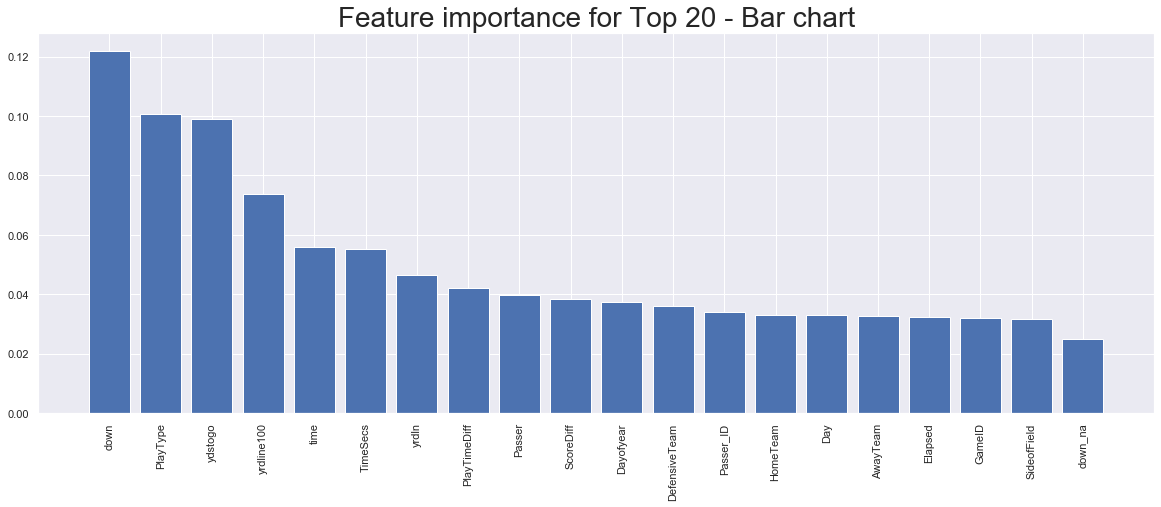

In [316]:
feat_imp_df_top20 = rf_feat_importance(m, X_train[top_20_feats])
plt.bar(feat_imp_df_top20['cols'], feat_imp_df_top20['imp'])
plt.xticks(rotation=90)
plt.title('Feature importance for Top 20 - Bar chart',fontsize=28)

#### As we can see the results actually improved by dropping insignificant features, and it scores around 81% on the test set.
#### 'PlayType' rose to the second spot in feature importance becoming the second feature above 0.1. I was most likely correlated with one (or a couple) of the dropped features e.g. 'PassAttempt', and now has a higher value as it is not shared with another feature.

### Conclusion
#### I will conclude the analysis and modelling exercise at this point, but might get back to it with a second part later, because there is certainly a lot more to explore about the model.
#### About the classifier, I emphasized how I always try to build something that has a purpose and is useful in the real world, and I think I managed to do that here. A good example would be a timeout by the offensive team (which can last up to 2 minutes if there is a commercial break, not counting the play calling time *before* the timeout) in a cruical situation, when the coach has a couple of plays, scenarios drawn up on the board to get the first down. These could be plugged into the model (with most of the features coming from game data e.g. 'ydstogo' that could be filled in continuously anyway) to see what the prediction is at an 80% success rate and support the decision making process with that.
### Lastly, I would like to thank you for reading this notebook and sticking with it till the end, I hope to finish more of these kind of projects in the near future.